In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib as mpl
import uproot3 as uproot
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import shutil
import array
from tqdm import tqdm
import math

print(xgb.__version__)

1.3.0


In [2]:
#f_e_plus_e_minus_test = uproot.open("checkout_IsoTropic_epem_batch1_test.root")["wcpselection"]
f_e_plus_e_minus = uproot.open("checkout_IsoTropic_epem_batch1.root")["wcpselection"]
#print(f_e_plus_e_minus.keys())
#f_e_plus_e_minus["T_PFeval"].show()
#f_e_plus_e_minus["T_BDTvars"].show()
#f_e_plus_e_minus["T_PFeval"].show()

In [3]:
# This is a list of the scalar variables saved for the numu tagger

numu3_var = ["numu_cc_flag_3",
"numu_cc_3_particle_type",
"numu_cc_3_max_length",
"numu_cc_3_track_length",#numu_cc_3_acc_track_length'
"numu_cc_3_max_length_all",
"numu_cc_3_max_muon_length",
"numu_cc_3_n_daughter_tracks",
"numu_cc_3_n_daughter_all"]

cosmict24_var = ["cosmict_flag_2",
"cosmict_2_filled",
"cosmict_2_particle_type",
"cosmict_2_n_muon_tracks",
"cosmict_2_total_shower_length",
"cosmict_2_flag_inside",
"cosmict_2_angle_beam",
"cosmict_2_flag_dir_weak",
"cosmict_2_dQ_dx_end",
"cosmict_2_dQ_dx_front",
"cosmict_2_theta",
"cosmict_2_phi",
"cosmict_2_valid_tracks",
"cosmict_flag_4", 
"cosmict_4_filled",
"cosmict_4_flag_inside",
"cosmict_4_angle_beam",
"cosmict_4_connected_showers"]

cosmict35_var = ["cosmict_flag_3",
"cosmict_3_filled",
"cosmict_3_flag_inside",
"cosmict_3_angle_beam",
"cosmict_3_flag_dir_weak",
"cosmict_3_dQ_dx_end",
"cosmict_3_dQ_dx_front",
"cosmict_3_theta",
"cosmict_3_phi",
"cosmict_3_valid_tracks",
"cosmict_flag_5",  
"cosmict_5_filled",
"cosmict_5_flag_inside",
"cosmict_5_angle_beam",
"cosmict_5_connected_showers"]

cosmict6_var = ["cosmict_flag_6", 
"cosmict_6_filled",
"cosmict_6_flag_dir_weak",
"cosmict_6_flag_inside",
"cosmict_6_angle"]

cosmict7_var = ["cosmict_flag_7",
"cosmict_7_filled",
"cosmict_7_flag_sec",
"cosmict_7_n_muon_tracks",
"cosmict_7_total_shower_length",
"cosmict_7_flag_inside",
"cosmict_7_angle_beam",
"cosmict_7_flag_dir_weak",
"cosmict_7_dQ_dx_end",
"cosmict_7_dQ_dx_front",
"cosmict_7_theta",
"cosmict_7_phi"]

cosmict8_var = ["cosmict_flag_8", 
"cosmict_8_filled",
"cosmict_8_flag_out",
"cosmict_8_muon_length",
"cosmict_8_acc_length"]

cosmict9_var = ["cosmict_flag_9",
"cosmic_flag",
"cosmic_filled"]

overall_var = ["cosmict_flag",
"numu_cc_flag"]

all_numu_scalars = []
all_numu_scalars += numu3_var
all_numu_scalars += cosmict24_var
all_numu_scalars += cosmict35_var
all_numu_scalars += cosmict6_var
all_numu_scalars += cosmict7_var
all_numu_scalars += cosmict8_var
all_numu_scalars += cosmict9_var
all_numu_scalars += overall_var

all_numu_scalars += ["cosmict_flag_1", "kine_reco_Enu", "match_isFC"]

In [4]:
# this is a list of the vector variables saved for the numu tagger (currently not using these for training, that would be more complicated)

var_numu1 = [#'weight',
             #'numu_cc_flag',
             #'cosmict_flag_1',
             #'numu_cc_flag_1',
             'numu_cc_1_particle_type',
             'numu_cc_1_length',
             'numu_cc_1_medium_dQ_dx',
             'numu_cc_1_dQ_dx_cut',
             'numu_cc_1_direct_length',
             'numu_cc_1_n_daughter_tracks',
             'numu_cc_1_n_daughter_all']
var_numu2 = [#'weight',
             #'numu_cc_flag',
             #'cosmict_flag_1',
             #'numu_cc_flag_2',
             'numu_cc_2_length',
             'numu_cc_2_total_length',
             'numu_cc_2_n_daughter_tracks',
             'numu_cc_2_n_daughter_all']
var_cos10 = [#'weight',
             #'numu_cc_flag',
             #'cosmict_flag_1',
             #'cosmict_flag_10',
             #'cosmict_10_flag_inside',
             'cosmict_10_vtx_z',
             'cosmict_10_flag_shower',
             'cosmict_10_flag_dir_weak',
             'cosmict_10_angle_beam',
             'cosmict_10_length']

all_numu_vectors = []
all_numu_vectors += var_numu1
all_numu_vectors += var_numu2
all_numu_vectors += var_cos10

In [5]:
taggerCMEAMC_var = ["cme_mu_energy","cme_energy","cme_mu_length","cme_length",
                "cme_angle_beam","anc_angle","anc_max_angle","anc_max_length",
                "anc_acc_forward_length","anc_acc_backward_length","anc_acc_forward_length1",
                "anc_shower_main_length","anc_shower_total_length","anc_flag_main_outside"]

taggerGAP_var = ["gap_flag_prolong_u","gap_flag_prolong_v","gap_flag_prolong_w","gap_flag_parallel",
                 "gap_n_points","gap_n_bad","gap_energy","gap_num_valid_tracks","gap_flag_single_shower"]

taggerHOL_var = ["hol_1_n_valid_tracks","hol_1_min_angle","hol_1_energy","hol_1_flag_all_shower","hol_1_min_length",
               "hol_2_min_angle","hol_2_medium_dQ_dx","hol_2_ncount","lol_3_angle_beam","lol_3_n_valid_tracks",
               "lol_3_min_angle","lol_3_vtx_n_segs","lol_3_shower_main_length","lol_3_n_out","lol_3_n_sum"]

taggerMGOMGT_var = ["mgo_energy","mgo_max_energy","mgo_total_energy","mgo_n_showers","mgo_max_energy_1",
                    "mgo_max_energy_2","mgo_total_other_energy","mgo_n_total_showers","mgo_total_other_energy_1",
                   "mgt_flag_single_shower","mgt_max_energy","mgt_total_other_energy","mgt_max_energy_1",
                   "mgt_e_indirect_max_energy","mgt_e_direct_max_energy","mgt_n_direct_showers",
                    "mgt_e_direct_total_energy","mgt_flag_indirect_max_pio","mgt_e_indirect_total_energy"]

taggerMIPQUALITY_var = ["mip_quality_energy","mip_quality_overlap","mip_quality_n_showers","mip_quality_n_tracks",
                        "mip_quality_flag_inside_pi0","mip_quality_n_pi0_showers","mip_quality_shortest_length",
                        "mip_quality_acc_length","mip_quality_shortest_angle","mip_quality_flag_proton"]

taggerBR1_var = ["br1_1_shower_type","br1_1_vtx_n_segs","br1_1_energy","br1_1_n_segs","br1_1_flag_sg_topology",
                 "br1_1_flag_sg_trajectory","br1_1_sg_length","br1_2_n_connected","br1_2_max_length",
                "br1_2_n_connected_1","br1_2_n_shower_segs","br1_2_max_length_ratio","br1_2_shower_length",
                 "br1_3_n_connected_p","br1_3_max_length_p","br1_3_n_shower_main_segs"]

taggerBR3_var = ["br3_1_energy","br3_1_n_shower_segments","br3_1_sg_flag_trajectory","br3_1_sg_direct_length",
                "br3_1_sg_length","br3_1_total_main_length","br3_1_total_length","br3_1_iso_angle",
                 "br3_1_sg_flag_topology","br3_2_n_ele","br3_2_n_other","br3_2_other_fid","br3_4_acc_length",
                 "br3_4_total_length","br3_7_min_angle","br3_8_max_dQ_dx","br3_8_n_main_segs"]

taggerBR4TRE_var = ["br4_1_shower_main_length","br4_1_shower_total_length","br4_1_min_dis","br4_1_energy",
                    "br4_1_flag_avoid_muon_check","br4_1_n_vtx_segs","br4_1_n_main_segs","br4_2_ratio_45",
                   "br4_2_ratio_35","br4_2_ratio_25","br4_2_ratio_15","br4_2_ratio1_45","br4_2_ratio1_35",
                   "br4_2_ratio1_25","br4_2_ratio1_15","br4_2_iso_angle","br4_2_iso_angle1","br4_2_angle",
                   "tro_3_stem_length","tro_3_n_muon_segs"]

taggerVIS1_var = ["vis_1_n_vtx_segs","vis_1_energy","vis_1_num_good_tracks","vis_1_max_angle",
                  "vis_1_max_shower_angle","vis_1_tmp_length1","vis_1_tmp_length2"]

taggerVIS2_var = ["vis_2_n_vtx_segs","vis_2_min_angle","vis_2_min_weak_track","vis_2_angle_beam","vis_2_min_angle1",
                 "vis_2_iso_angle1","vis_2_min_medium_dQ_dx","vis_2_min_length","vis_2_sg_length","vis_2_max_angle",
                 "vis_2_max_weak_track"]

taggerPI01_var = ["pio_1_mass","pio_1_pio_type","pio_1_energy_1","pio_1_energy_2","pio_1_dis_1","pio_1_dis_2","pio_mip_id"]

taggerSTEMDIRBR2_var = ["stem_dir_flag_single_shower","stem_dir_angle","stem_dir_energy","stem_dir_angle1",
                        "stem_dir_angle2","stem_dir_angle3","stem_dir_ratio","br2_num_valid_tracks",
                        "br2_n_shower_main_segs","br2_max_angle","br2_sg_length","br2_flag_sg_trajectory"]

taggerSTLLEMBRM_var = ["stem_len_energy","stem_len_length","stem_len_flag_avoid_muon_check","stem_len_num_daughters",
                      "stem_len_daughter_length","brm_n_mu_segs","brm_Ep","brm_acc_length","brm_shower_total_length",
                      "brm_connected_length","brm_n_size","brm_acc_direct_length","brm_n_shower_main_segs",
                       "brm_n_mu_main","lem_shower_main_length","lem_n_3seg","lem_e_charge","lem_e_dQdx",
                       "lem_shower_num_main_segs"]

taggerSTWSPT_var = ["stw_1_energy","stw_1_dis","stw_1_dQ_dx","stw_1_flag_single_shower","stw_1_n_pi0",
                    "stw_1_num_valid_tracks","spt_shower_main_length","spt_shower_total_length","spt_angle_beam",
                    "spt_angle_vertical","spt_max_dQ_dx","spt_angle_beam_1","spt_angle_drift","spt_angle_drift_1",
                    "spt_num_valid_tracks","spt_n_vtx_segs","spt_max_length"]

taggerMIP_var = ["mip_energy","mip_n_end_reduction","mip_n_first_mip","mip_n_first_non_mip","mip_n_first_non_mip_1",
                "mip_n_first_non_mip_2","mip_vec_dQ_dx_0","mip_vec_dQ_dx_1","mip_max_dQ_dx_sample",
                "mip_n_below_threshold","mip_n_below_zero","mip_n_lowest","mip_n_highest","mip_lowest_dQ_dx",
                 "mip_highest_dQ_dx","mip_medium_dQ_dx","mip_stem_length","mip_length_main","mip_length_total",
                 "mip_angle_beam","mip_iso_angle","mip_n_vertex","mip_n_good_tracks","mip_E_indirect_max_energy",
                 "mip_flag_all_above","mip_min_dQ_dx_5","mip_n_other_vertex","mip_n_stem_size",
                 "mip_flag_stem_trajectory","mip_min_dis"]

taggerAdditional_Var = ["mip_vec_dQ_dx_2","mip_vec_dQ_dx_3","mip_vec_dQ_dx_4","mip_vec_dQ_dx_5","mip_vec_dQ_dx_6",
                        "mip_vec_dQ_dx_7","mip_vec_dQ_dx_8","mip_vec_dQ_dx_9","mip_vec_dQ_dx_10","mip_vec_dQ_dx_11",
                        "mip_vec_dQ_dx_12","mip_vec_dQ_dx_13","mip_vec_dQ_dx_14","mip_vec_dQ_dx_15",
                        "mip_vec_dQ_dx_16","mip_vec_dQ_dx_17","mip_vec_dQ_dx_18","mip_vec_dQ_dx_19"]


all_nue_scalars = []
all_nue_scalars += taggerCMEAMC_var
all_nue_scalars += taggerGAP_var
all_nue_scalars += taggerHOL_var
all_nue_scalars += taggerMGOMGT_var
all_nue_scalars += taggerMIPQUALITY_var
all_nue_scalars += taggerBR1_var
all_nue_scalars += taggerBR3_var
all_nue_scalars += taggerBR4TRE_var
all_nue_scalars += taggerSTEMDIRBR2_var
all_nue_scalars += taggerSTLLEMBRM_var
all_nue_scalars += taggerSTWSPT_var
all_nue_scalars += taggerMIP_var
all_nue_scalars += taggerVIS1_var
all_nue_scalars += taggerVIS2_var
all_nue_scalars += taggerPI01_var
all_nue_scalars += taggerAdditional_Var

# removing this line, these variables are already in all_numu_scalars
#all_nue_scalars += ["kine_reco_Enu", "match_isFC"]

In [6]:
taggerTRO5_var = ["tro_5_v_max_angle","tro_5_v_min_angle","tro_5_v_max_length","tro_5_v_iso_angle","tro_5_v_n_vtx_segs",
                "tro_5_v_min_count","tro_5_v_max_count","tro_5_v_energy"]
 
taggerTRO4_var = ["tro_4_v_dir2_mag","tro_4_v_angle","tro_4_v_angle1","tro_4_v_angle2","tro_4_v_length","tro_4_v_length1",
                "tro_4_v_medium_dQ_dx","tro_4_v_end_dQ_dx","tro_4_v_energy","tro_4_v_shower_main_length","tro_4_v_flag_shower_trajectory"]

taggerTRO2_var = ["tro_2_v_energy","tro_2_v_stem_length","tro_2_v_iso_angle","tro_2_v_max_length","tro_2_v_angle"]
 
taggerTRO1_var = ["tro_1_v_particle_type","tro_1_v_flag_dir_weak","tro_1_v_min_dis","tro_1_v_sg1_length","tro_1_v_shower_main_length",
                "tro_1_v_max_n_vtx_segs","tro_1_v_tmp_length","tro_1_v_medium_dQ_dx","tro_1_v_dQ_dx_cut","tro_1_v_flag_shower_topology"]
 
taggerSTW4_var = ["stw_4_v_angle","stw_4_v_dis","stw_4_v_energy"]
 
taggerSTW3_var = ["stw_3_v_angle","stw_3_v_dir_length","stw_3_v_energy","stw_3_v_medium_dQ_dx"]
 
taggerSTW2_var = ["stw_2_v_medium_dQ_dx","stw_2_v_energy","stw_2_v_angle","stw_2_v_dir_length","stw_2_v_max_dQ_dx"]
 
taggerSIG2_var = ["sig_2_v_energy","sig_2_v_shower_angle","sig_2_v_flag_single_shower","sig_2_v_medium_dQ_dx",
                "sig_2_v_start_dQ_dx"]
taggerSIG1_var = ["sig_1_v_angle","sig_1_v_flag_single_shower","sig_1_v_energy","sig_1_v_energy_1"]
 
taggerPI02_var = ["pio_2_v_dis2","pio_2_v_angle2","pio_2_v_acc_length"]#"pio_mip_id"
 
taggerLOL2_var = ["lol_2_v_length","lol_2_v_angle","lol_2_v_type","lol_2_v_vtx_n_segs","lol_2_v_energy",
                 "lol_2_v_shower_main_length","lol_2_v_flag_dir_weak"]
taggerLOL1_var = ["lol_1_v_energy","lol_1_v_vtx_n_segs","lol_1_v_nseg","lol_1_v_angle"]
 
taggerBR3TAGGER6_var = ["br3_6_v_angle","br3_6_v_angle1","br3_6_v_flag_shower_trajectory","br3_6_v_direct_length",
               "br3_6_v_length","br3_6_v_n_other_vtx_segs","br3_6_v_energy"]

taggerBR3TAGGER5_var = ["br3_5_v_dir_length","br3_5_v_total_length","br3_5_v_flag_avoid_muon_check","br3_5_v_n_seg",
               "br3_5_v_angle","br3_5_v_sg_length","br3_5_v_energy","br3_5_v_n_segs","br3_5_v_shower_main_length",
                "br3_5_v_shower_total_length"]

taggerBR3TAGGER3_var = ["br3_3_v_energy","br3_3_v_angle","br3_3_v_dir_length","br3_3_v_length"]

vector_lists = [
    taggerTRO5_var,
    taggerTRO4_var,
    taggerTRO2_var,
    taggerTRO1_var,
    taggerSTW4_var,
    taggerSTW3_var,
    taggerSTW2_var,
    taggerSIG2_var,
    taggerSIG1_var,
    taggerPI02_var,
    taggerLOL2_var,
    taggerLOL1_var,
    taggerBR3TAGGER6_var,
    taggerBR3TAGGER5_var,
    taggerBR3TAGGER3_var
]

all_nue_vectors = []
all_nue_vectors += taggerTRO5_var
all_nue_vectors += taggerTRO4_var
all_nue_vectors += taggerTRO2_var
all_nue_vectors += taggerTRO1_var
all_nue_vectors += taggerSTW4_var
all_nue_vectors += taggerSTW3_var
all_nue_vectors += taggerSTW2_var
all_nue_vectors += taggerSIG2_var
all_nue_vectors += taggerSIG1_var
all_nue_vectors += taggerPI02_var
all_nue_vectors += taggerLOL2_var
all_nue_vectors += taggerLOL1_var
all_nue_vectors += taggerBR3TAGGER6_var
all_nue_vectors += taggerBR3TAGGER5_var
all_nue_vectors += taggerBR3TAGGER3_var

In [7]:
extra_variables = [
    "run",
    "subrun",
    "event",
    "nuvtx_diff",
    "showervtx_diff",
    "muonvtx_diff",
    "truth_isCC",
    "truth_vtxInside",
    "truth_nuPdg",
    "truth_nuEnergy",
    "truth_nuIntType",
    "truth_energyInside",
    "weight_spline",
    "weight_cv",
    "weight_lee",
    "event_type",
    "weight",
    "lowEweight"
]

numu_bdt_score_variables = [
    "cosmict_10_score",
    "numu_1_score",
    "numu_2_score"
]

nue_bdt_score_variables = [
    "tro_5_score",
    "tro_4_score",
    "tro_2_score",
    "tro_1_score",
    "stw_4_score",
    "stw_3_score",
    "stw_2_score",
    "sig_2_score",
    "sig_1_score",
    "pio_2_score",
    "lol_2_score",
    "lol_1_score",
    "br3_6_score",
    "br3_5_score",
    "br3_3_score"
]

kine_scalar_vars = [
    "kine_reco_add_energy",
    "kine_pio_mass",
    "kine_pio_flag",
    "kine_pio_vtx_dis",
    "kine_pio_energy_1",
    "kine_pio_theta_1",
    "kine_pio_phi_1",
    "kine_pio_dis_1",
    "kine_pio_energy_2",
    "kine_pio_theta_2",
    "kine_pio_phi_2",
    "kine_pio_dis_2",
    "kine_pio_angle"
]

kine_vector_vars = [
    "kine_energy_particle",
    "kine_energy_info",
    "kine_particle_type",
    "kine_energy_included",
]

In [8]:
extra_bdt_variables = [
    "nue_score",
    "numu_score"
]

eval_mc_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
    "weight_spline", # this and remaining only make sense for MC
    "weight_cv",
    "match_completeness_energy",
    "truth_nuEnergy",
    "truth_energyInside",
    "truth_electronInside",
    "truth_nuPdg",
    "truth_isCC",
    "truth_isFC",
    "truth_vtxInside",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "truth_nuTime",
]

eval_data_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
]

pf_eval_mc_variables = [
    "truth_NprimPio",
    "truth_NCDelta",
    "nuvtx_diff",
    "showervtx_diff",
    "reco_showerKE",
    "truth_pio_energy_1",
    "truth_pio_energy_2",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
]

pf_eval_data_variables = [ # also use these for dirt
    "reco_showerKE",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum"
]

dedicated_pf_eval_mc_variables = [
    "truth_pdg", 
    "truth_mother", 
    "truth_startMomentum",
    "truth_startXYZT",
]

In [9]:
# loading NC Delta file

# NC delta run 1 only for training, same as past BDT

f_e_plus_e_minus = uproot.open("checkout_IsoTropic_epem_batch1.root")["wcpselection"]

f_e_plus_e_minus_bdt = f_e_plus_e_minus["T_BDTvars"].pandas.df(
    all_numu_scalars[:-2] + all_nue_scalars + numu_bdt_score_variables + nue_bdt_score_variables + extra_bdt_variables, flatten=False)
f_e_plus_e_minus_eval = f_e_plus_e_minus["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_e_plus_e_minus_pfeval = f_e_plus_e_minus["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_e_plus_e_minus_kine = f_e_plus_e_minus["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_e_plus_e_minus_pot = f_e_plus_e_minus["T_pot"].pandas.df("pot_tor875good", flatten=False)

f_e_plus_e_minus_file_POT = np.sum(f_e_plus_e_minus_pot["pot_tor875good"].to_numpy())


f_e_plus_e_minus_df = pd.concat([f_e_plus_e_minus_bdt, f_e_plus_e_minus_eval, f_e_plus_e_minus_pfeval, f_e_plus_e_minus_kine], axis=1, sort=False)

f_e_plus_e_minus_df = f_e_plus_e_minus_df#.query("kine_reco_Enu > 0 and match_isFC==1")

del f_e_plus_e_minus
del f_e_plus_e_minus_bdt
del f_e_plus_e_minus_eval
del f_e_plus_e_minus_pfeval
del f_e_plus_e_minus_kine
del f_e_plus_e_minus_pot

f_e_plus_e_minus_df["isEXT"] = [0 for i in range(f_e_plus_e_minus_df.shape[0])]

print(f_e_plus_e_minus_file_POT)
print(f_e_plus_e_minus_df.shape[0])



0.0
24288


In [10]:
all_df = f_e_plus_e_minus_df

In [11]:
# adding proton and pion nums, adjusting em scale for reco_showerKE and kine_reco_Enu

proton_nums = []
track_nums = []
energy_lists = all_df["kine_energy_particle"].to_numpy()
pdg_lists = all_df["kine_particle_type"].to_numpy()
for i in tqdm(range(all_df.shape[0])):
    proton_num = 0
    track_num = 0
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    for j in range(len(energy_list)):
        if abs(pdg_list[j]) == 2212 and energy_list[j] > 35.:
            proton_num += 1
        if abs(pdg_list[j]) == 13 or abs(pdg_list[j]) == 211 and energy_list[j] > 10.: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            track_num += 1
    proton_nums.append(proton_num)
    track_nums.append(track_num)
all_df["num_protons"] = proton_nums
all_df["num_other_tracks"] = track_nums

uncorrected_reco_showerKE = all_df["reco_showerKE"].to_numpy()
all_df["reco_showerKE"] = uncorrected_reco_showerKE * 1000.


100%|██████████████████████████████████| 24288/24288 [00:01<00:00, 17321.69it/s]


In [12]:
reco_true_distances = []
reco_true_distances_x = []
reco_true_distances_y = []
reco_true_distances_z = []

reco_vtx_Xs = all_df["reco_nuvtxX"].to_numpy()
reco_vtx_Ys = all_df["reco_nuvtxY"].to_numpy()
reco_vtx_Zs = all_df["reco_nuvtxZ"].to_numpy()

true_vtx_Xs = [_[0][0] for _ in all_df["truth_startXYZT"]]
true_vtx_Ys = [_[0][1] for _ in all_df["truth_startXYZT"]]
true_vtx_Zs = [_[0][2] for _ in all_df["truth_startXYZT"]]

for i in range(all_df.shape[0]):
    
    #print(reco_vtx_Zs[i], true_vtx_Zs[i])
    reco_true_distances.append(np.sqrt((reco_vtx_Xs[i] - true_vtx_Xs[i]) * (reco_vtx_Xs[i] - true_vtx_Xs[i])
                                      + (reco_vtx_Ys[i] - true_vtx_Ys[i]) * (reco_vtx_Ys[i] - true_vtx_Ys[i])
                                      + (reco_vtx_Zs[i] - true_vtx_Zs[i]) * (reco_vtx_Zs[i] - true_vtx_Zs[i])))
    
    reco_true_distances_x.append(np.abs(reco_vtx_Xs[i] - true_vtx_Xs[i]))
    reco_true_distances_y.append(np.abs(reco_vtx_Ys[i] - true_vtx_Ys[i]))
    reco_true_distances_z.append(np.abs(reco_vtx_Zs[i] - true_vtx_Zs[i]))

all_df["reco_true_distance_x"] = reco_true_distances_x
all_df["reco_true_distance_y"] = reco_true_distances_y
all_df["reco_true_distance_z"] = reco_true_distances_z
all_df["reco_true_distance"] = reco_true_distances


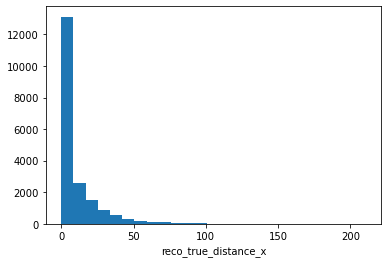

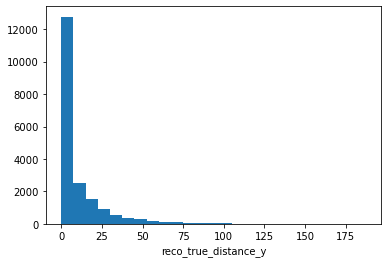

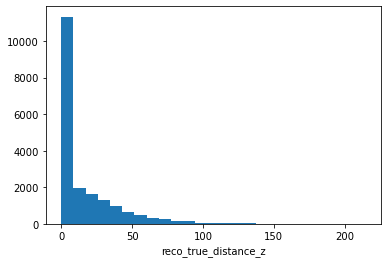

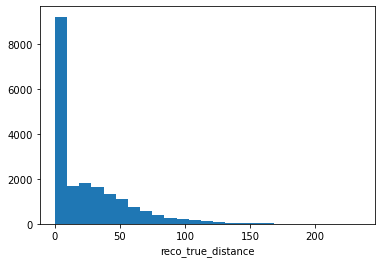

'bad_vtx = all_df.query("reco_true_distance > 1000")\n\nfor i, row in bad_vtx.iterrows():\n    print(row["run"], row["subrun"], row["event"], "         ", row["reco_true_distance"])'

In [13]:
all_df_with_generic = all_df.query("kine_reco_Enu > 0")

plt.figure()
plt.hist(all_df_with_generic["reco_true_distance_x"].to_numpy(), bins=25)
plt.xlabel("reco_true_distance_x")
plt.show()

plt.figure()
plt.hist(all_df_with_generic["reco_true_distance_y"].to_numpy(), bins=25)
plt.xlabel("reco_true_distance_y")
plt.show()

plt.figure()
plt.hist(all_df_with_generic["reco_true_distance_z"].to_numpy(), bins=25)
plt.xlabel("reco_true_distance_z")
plt.show()

plt.figure()
plt.hist(all_df_with_generic["reco_true_distance"].to_numpy(), bins=25)
plt.xlabel("reco_true_distance")
plt.show()

"""bad_vtx = all_df.query("reco_true_distance > 1000")

for i, row in bad_vtx.iterrows():
    print(row["run"], row["subrun"], row["event"], "         ", row["reco_true_distance"])"""

In [14]:
photon_thetas = []
photon_phis = []
photon_energies = []

truth_pdgs = all_df["truth_pdg"].to_numpy()
truth_mothers = all_df["truth_mother"].to_numpy()
truth_startMomentums = all_df["truth_startMomentum"].to_numpy()

electron_energies = []
positron_energies = []

leading_energies = []
subleading_energies = []

energy_asymmetries = []

leading_thetas = []
leading_phis = []

electron_thetas = []
electron_phis = []
positron_thetas = []
positron_phis = []

total_momentums_theta = []
total_momentums_phi = []

opening_angles = []
invariant_masses = []

for i in tqdm(range(all_df.shape[0])):
    
    #for i in [0]:
    
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]
    
    #print(truth_pdg_list)
    #print(truth_mother_list)
    #print(truth_startMomentum_list)

    for j in range(len(truth_pdg_list)):

        if truth_mother_list[j] != 0: # non-primary
            continue
            
        if truth_pdg_list[j] == 11: # primary electron
            
            electron_4_momentum = truth_startMomentum_list[j]
            
            if electron_4_momentum[3] < 0:
                print("invalid primary electron!")
            
            electron_momentum_perp = np.sqrt(electron_4_momentum[0] * electron_4_momentum[0] + electron_4_momentum[1] * electron_4_momentum[1])
            electron_theta = np.arctan2(electron_momentum_perp, electron_4_momentum[2]) * 180. / np.pi
            electron_phi = np.arctan2(electron_4_momentum[0], electron_4_momentum[1]) * 180. / np.pi
            electron_energy = electron_4_momentum[3] * 1000.
            
        if truth_pdg_list[j] == -11: # primary positron
            
            positron_4_momentum = truth_startMomentum_list[j]
            
            if positron_4_momentum[3] < 0:
                print("invalid primary positron!")
            
            positron_momentum_perp = np.sqrt(positron_4_momentum[0] * positron_4_momentum[0] + positron_4_momentum[1] * positron_4_momentum[1])
            positron_theta = np.arctan2(positron_momentum_perp, positron_4_momentum[2]) * 180. / np.pi
            positron_phi = np.arctan2(positron_4_momentum[0], positron_4_momentum[1]) * 180. / np.pi
            positron_energy = positron_4_momentum[3] * 1000.

        
    momentums_dot_product = (electron_4_momentum[0] * positron_4_momentum[0] 
                             + electron_4_momentum[1] * positron_4_momentum[1]
                             + electron_4_momentum[2] * positron_4_momentum[2])
    
    normalized_dot_product = momentums_dot_product / (electron_4_momentum[3] * positron_4_momentum[3])
        
    opening_angle = np.arccos(normalized_dot_product) * 180. / np.pi

    electron_energies.append(electron_energy)
    positron_energies.append(positron_energy)
    
    if electron_energy > positron_energy:
        leading_energies.append(electron_energy)
        subleading_energies.append(positron_energy)
        leading_thetas.append(electron_theta)
        leading_phis.append(electron_phi)
    else:
        leading_energies.append(positron_energy)
        subleading_energies.append(electron_energy)
        leading_thetas.append(positron_theta)
        leading_phis.append(positron_phi)
    
    total_4_momentum = np.array(electron_4_momentum) + np.array(positron_4_momentum)
    total_momentum_perp = np.sqrt(total_4_momentum[0] * total_4_momentum[0] + total_4_momentum[1] * total_4_momentum[1])
    total_theta = np.arctan2(total_momentum_perp, total_4_momentum[2]) * 180. / np.pi
    total_phi = np.arctan2(total_4_momentum[0], total_4_momentum[1]) * 180. / np.pi
    total_energy = total_4_momentum[3] * 1000.
    total_momentums_theta.append(total_theta)
    total_momentums_phi.append(total_phi)
        
    energy_asymmetries.append(leading_energies[-1] / (leading_energies[-1] + subleading_energies[-1]))
    
    invariant_masses.append(np.sqrt(2. * (electron_energy * positron_energy - momentums_dot_product)))
    
    electron_thetas.append(electron_theta)
    electron_phis.append(electron_phi)
    positron_thetas.append(positron_theta)
    positron_phis.append(positron_phi)
    opening_angles.append(opening_angle)
    
all_df["true_electron_energy"] = electron_energies
all_df["true_positron_energy"] = positron_energies

all_df["true_total_energy"] = np.array(electron_energies) + np.array(positron_energies)

all_df["true_leading_shower_energy"] = leading_energies
all_df["true_subleading_shower_energy"] = subleading_energies

all_df["true_leading_shower_theta"] = leading_thetas
all_df["true_leading_shower_phi"] = leading_phis

all_df["true_electron_theta"] = electron_thetas
all_df["true_electron_phi"] = electron_phis
all_df["true_positron_theta"] = positron_thetas
all_df["true_positron_phi"] = positron_phis

all_df["true_opening_angle"] = opening_angles

all_df["true_invariant_mass"] = invariant_masses

all_df["true_leading_energy_over_total_energy"] = energy_asymmetries

all_df["total_momentum_theta"] = total_momentums_theta
all_df["total_momentum_phi"] = total_momentums_phi



100%|███████████████████████████████████| 24288/24288 [00:05<00:00, 4187.16it/s]


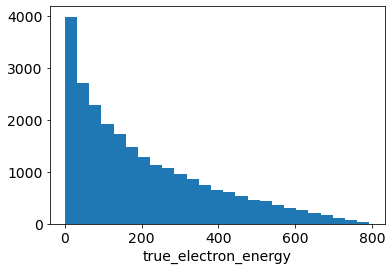

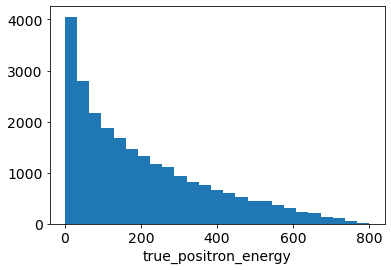

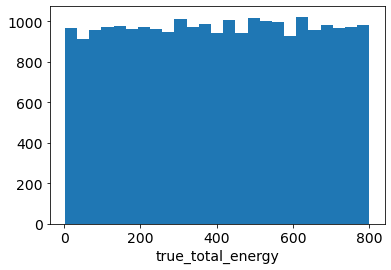

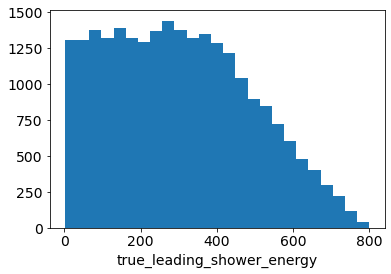

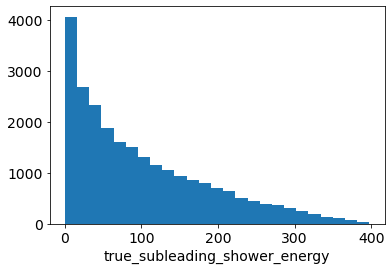

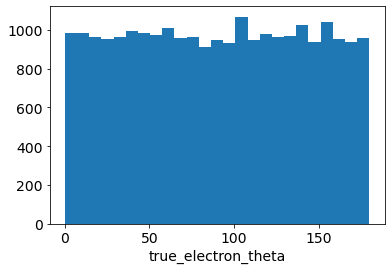

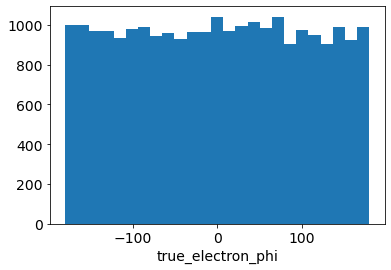

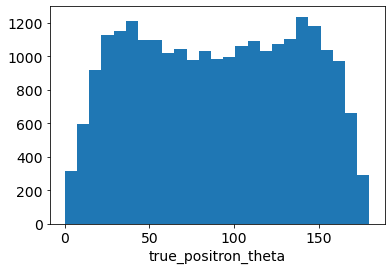

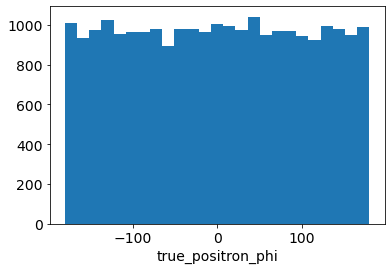

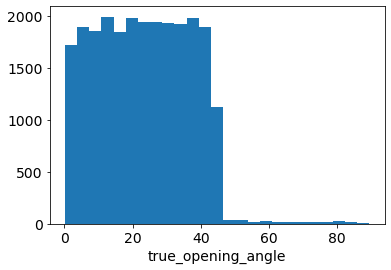

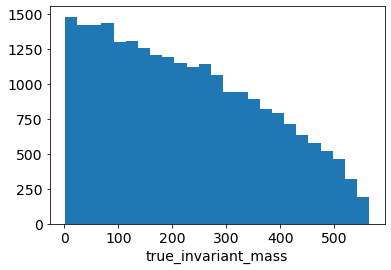

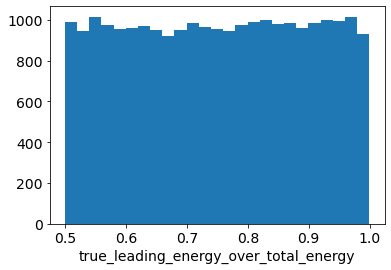

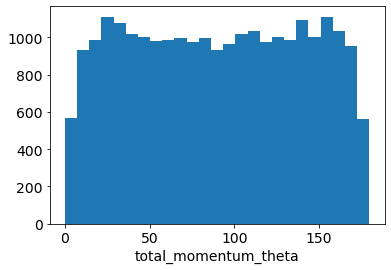

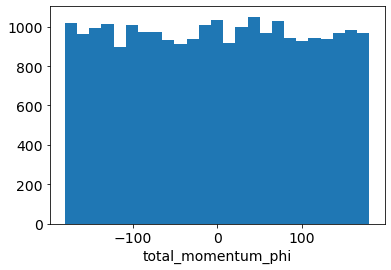

In [15]:
mpl.rcParams.update({'font.size': 14})

plt.figure()
plt.hist(all_df["true_electron_energy"].to_numpy(), bins=25)
plt.xlabel("true_electron_energy")
plt.show()

plt.figure()
plt.hist(all_df["true_positron_energy"].to_numpy(), bins=25)
plt.xlabel("true_positron_energy")
plt.show()

plt.figure()
plt.hist(all_df["true_total_energy"].to_numpy(), bins=25)
plt.xlabel("true_total_energy")
plt.show()

plt.figure()
plt.hist(all_df["true_leading_shower_energy"].to_numpy(), bins=25)
plt.xlabel("true_leading_shower_energy")
plt.show()

plt.figure()
plt.hist(all_df["true_subleading_shower_energy"].to_numpy(), bins=25)
plt.xlabel("true_subleading_shower_energy")
plt.show()


plt.figure()
plt.hist(all_df["true_electron_theta"].to_numpy(), bins=25)
plt.xlabel("true_electron_theta")
plt.show()

plt.figure()
plt.hist(all_df["true_electron_phi"].to_numpy(), bins=25)
plt.xlabel("true_electron_phi")
plt.show()

plt.figure()
plt.hist(all_df["true_positron_theta"].to_numpy(), bins=25)
plt.xlabel("true_positron_theta")
plt.show()

plt.figure()
plt.hist(all_df["true_positron_phi"].to_numpy(), bins=25)
plt.xlabel("true_positron_phi")
plt.show()


plt.figure()
plt.hist(all_df["true_opening_angle"].to_numpy(), bins=25)
plt.xlabel("true_opening_angle")
plt.show()


plt.figure()
plt.hist(all_df["true_invariant_mass"].to_numpy(), bins=25)
plt.xlabel("true_invariant_mass")
plt.show()

plt.figure()
plt.hist(all_df["true_leading_energy_over_total_energy"].to_numpy(), bins=25)
plt.xlabel("true_leading_energy_over_total_energy")
plt.show()

plt.figure()
plt.hist(all_df["total_momentum_theta"].to_numpy(), bins=25)
plt.xlabel("total_momentum_theta")
plt.show()

plt.figure()
plt.hist(all_df["total_momentum_phi"].to_numpy(), bins=25)
plt.xlabel("total_momentum_phi")
plt.show()




In [16]:
photon_thetas = []
photon_phis = []
photon_energies = []

reco_pdgs = all_df["reco_pdg"].to_numpy()
reco_mothers = all_df["reco_mother"].to_numpy()
reco_startMomentums = all_df["reco_startMomentum"].to_numpy()

nums_reco_showers = []
nums_reco_electrons_or_positrons = []
nums_reco_photons = []
nums_reco_20_MeV_showers = []

opening_angles = []
energy_asymmetries = []
invariant_masses = []

primary_thetas = []

for i in tqdm(range(all_df.shape[0])):
    #for i in range(62, 63):
    
    reco_pdg_list = reco_pdgs[i]
    reco_mother_list = reco_mothers[i]
    reco_startMomentum_list = reco_startMomentums[i]
    
    # looping to get the two highest energy showers
    num_reco_showers = 0
    primary_shower_energy = -1.
    primary_shower_4_momentum = [-1., -1., -1., -1.]
    secondary_shower_energy = -1.
    secondary_shower_4_momentum = [-1., -1., -1., -1.]
    opening_angle = -1.
    invariant_mass = -1.
    for j in range(len(reco_pdg_list)):        
        #if reco_mother_list[j] != 0: # non-primary
        #    continue
        if abs(reco_pdg_list[j]) == 11 or reco_pdg_list[j] == 22: # reco shower
            num_reco_showers += 1
            
            energy = reco_startMomentum_list[j][3] * 1000.
            if energy > primary_shower_energy:
                secondary_shower_energy = primary_shower_energy
                secondary_shower_4_momentum = primary_shower_4_momentum
                primary_shower_energy = energy
                primary_shower_4_momentum = reco_startMomentum_list[j]
            elif energy > secondary_shower_energy:
                secondary_shower_energy = energy
                secondary_shower_4_momentum = reco_startMomentum_list[j]
    momentums_dot_product = (primary_shower_4_momentum[0] * secondary_shower_4_momentum[0] 
                             + primary_shower_4_momentum[1] * secondary_shower_4_momentum[1]
                             + primary_shower_4_momentum[2] * secondary_shower_4_momentum[2])
    
    normalized_dot_product = momentums_dot_product / (electron_4_momentum[3] * positron_4_momentum[3])

    if primary_shower_4_momentum[3] == -1. and secondary_shower_4_momentum[3] == -1.:
        primary_thetas.append(-1.)
        opening_angles.append(-1.)
        energy_asymmetries.append(-1.)
        invariant_masses.append(-1.)
    elif secondary_shower_4_momentum[3] == -1.: # can reconstruct the primary info, but not the 2 shower info
        opening_angles.append(-1.)
        energy_asymmetries.append(-1.)
        invariant_masses.append(-1.)
        primary_momentum_perp = np.sqrt(primary_shower_4_momentum[0] * primary_shower_4_momentum[0] + primary_shower_4_momentum[1] * primary_shower_4_momentum[1])
        primary_thetas.append(np.arctan2(primary_momentum_perp, primary_shower_4_momentum[2]) * 180. / np.pi)
    else:
        opening_angles.append(np.arccos(normalized_dot_product) * 180. / np.pi)
        energy_asymmetries.append(primary_shower_energy / (primary_shower_energy + secondary_shower_energy))
        invariant_masses.append(np.sqrt(2. * (primary_shower_energy * secondary_shower_energy - momentums_dot_product)))
        
        primary_momentum_perp = np.sqrt(primary_shower_4_momentum[0] * primary_shower_4_momentum[0] + primary_shower_4_momentum[1] * primary_shower_4_momentum[1])
        primary_thetas.append(np.arctan2(primary_momentum_perp, primary_shower_4_momentum[2]) * 180. / np.pi)
        
    num_reco_electrons_or_positrons = 0
    num_reco_photons = 0
    
    num_20_MeV_showers = 0
    
    # looping over all particles to get particle multiplicities
    for j in range(len(reco_pdg_list)):

        #if reco_mother_list[j] != 0: # non-primary
        #    continue
            
        if abs(reco_pdg_list[j]) == 11: # primary electron / positron
            num_reco_electrons_or_positrons += 1
            if reco_startMomentum_list[j][3] * 1000. > 20.:
                num_20_MeV_showers += 1
        
        if reco_pdg_list[j] == 22:
            num_reco_photons += 1
            if reco_startMomentum_list[j][3] * 1000. > 20.:
                num_20_MeV_showers += 1
                
    nums_reco_electrons_or_positrons.append(num_reco_electrons_or_positrons)
    nums_reco_photons.append(num_reco_photons)
    nums_reco_20_MeV_showers.append(num_20_MeV_showers)
    nums_reco_showers.append(num_reco_showers)
    
    #print(reco_pdg_list)
    #print(reco_mother_list)
    #print(reco_startMomentum_list)
    #print(num_reco_showers)
    #print(primary_thetas[-1])
    
all_df["num_reco_showers"] = nums_reco_showers
all_df["num_reco_electrons_or_positrons"] = nums_reco_electrons_or_positrons
all_df["num_reco_photons"] = nums_reco_photons
all_df["num_reco_greater_than_20_MeV_showers"] = nums_reco_20_MeV_showers


all_df["reco_two_leading_showers_opening_angle"] = opening_angles
all_df["reco_two_leading_showers_leading_energy_over_total_energy"] = energy_asymmetries
all_df["reco_two_leading_showers_invariant_mass"] = invariant_masses

all_df["reco_leading_shower_theta"] = primary_thetas


  0%|                                                 | 0/24288 [00:00<?, ?it/s]/var/folders/td/wmgdw7j14kgbhp9x17ycmhz40000gn/T/ipykernel_50448/1856419988.py:68: RuntimeWarning: invalid value encountered in arccos
  opening_angles.append(np.arccos(normalized_dot_product) * 180. / np.pi)
100%|███████████████████████████████████| 24288/24288 [00:05<00:00, 4202.77it/s]


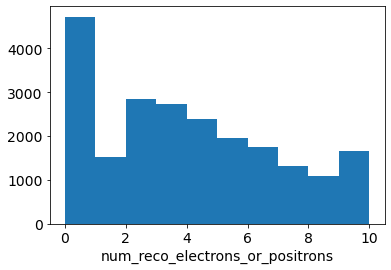

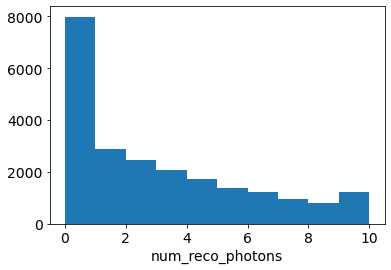

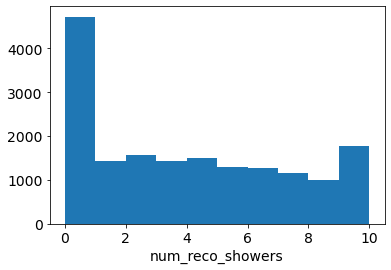

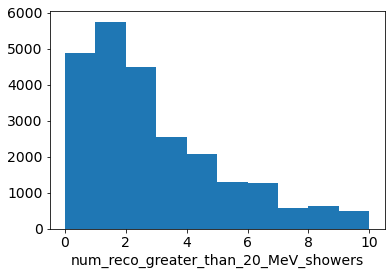

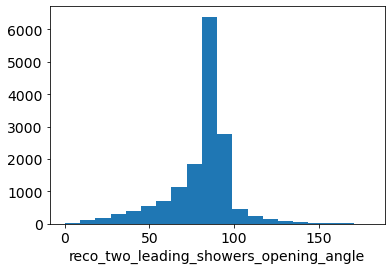

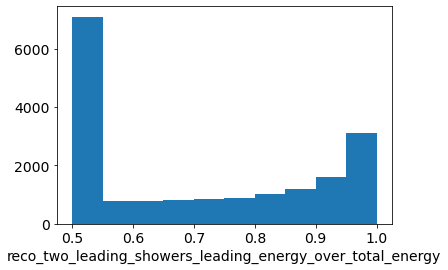

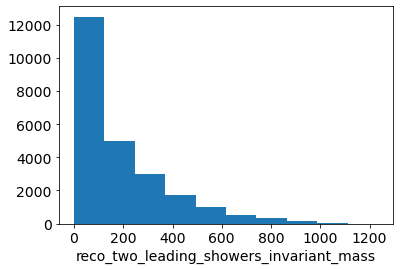

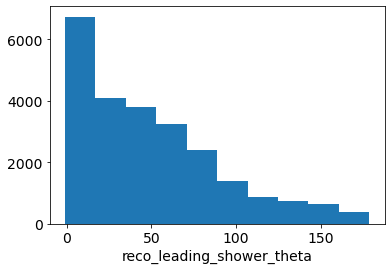

In [17]:
plt.figure()
plt.hist(all_df["num_reco_electrons_or_positrons"].to_numpy(), bins=10, range=(0, 10))
plt.xlabel("num_reco_electrons_or_positrons")
plt.show()

plt.figure()
plt.hist(all_df["num_reco_photons"].to_numpy(), bins=10, range=(0, 10))
plt.xlabel("num_reco_photons")
plt.show()


plt.figure()
plt.hist(all_df["num_reco_showers"].to_numpy(), bins=10, range=(0, 10))
plt.xlabel("num_reco_showers")
plt.show()


plt.figure()
plt.hist(all_df["num_reco_greater_than_20_MeV_showers"].to_numpy(), bins=10, range=(0, 10))
plt.xlabel("num_reco_greater_than_20_MeV_showers")
plt.show()


plt.figure()
plt.hist(all_df["reco_two_leading_showers_opening_angle"].to_numpy(), bins=20, range=(0, 180))
plt.xlabel("reco_two_leading_showers_opening_angle")
plt.show()

plt.figure()
plt.hist(all_df["reco_two_leading_showers_leading_energy_over_total_energy"].to_numpy(), range=(0.5, 1))
plt.xlabel("reco_two_leading_showers_leading_energy_over_total_energy")
plt.show()

plt.figure()
plt.hist(all_df["reco_two_leading_showers_invariant_mass"].to_numpy())
plt.xlabel("reco_two_leading_showers_invariant_mass")
plt.show()

plt.figure()
plt.hist(all_df["reco_leading_shower_theta"].to_numpy())
plt.xlabel("reco_leading_shower_theta")
plt.show()


Text(0.5, 1.0, 'All e+e- batch 1')

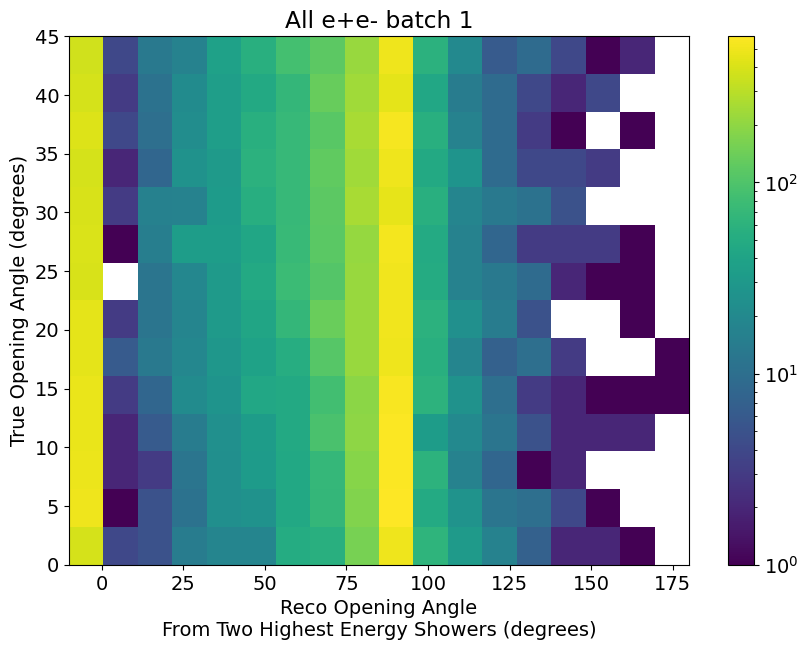

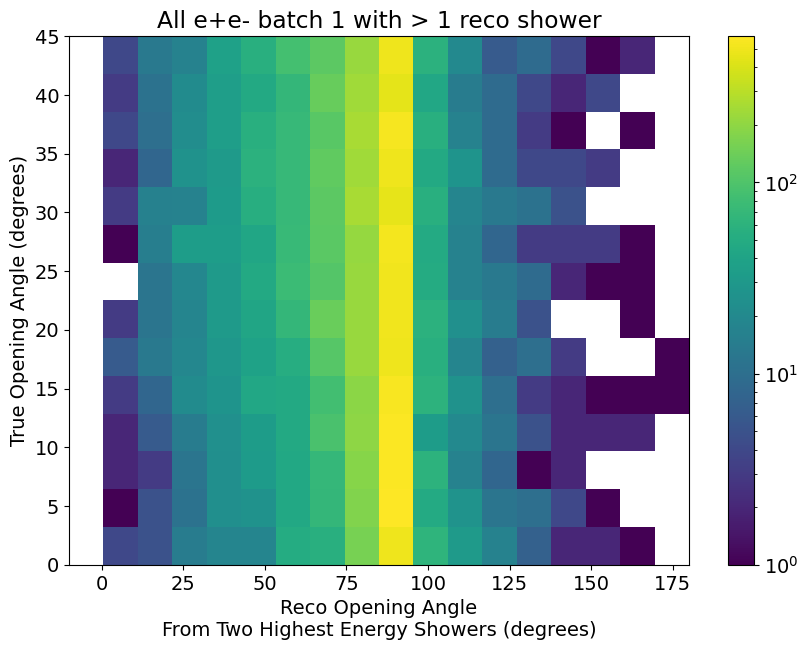

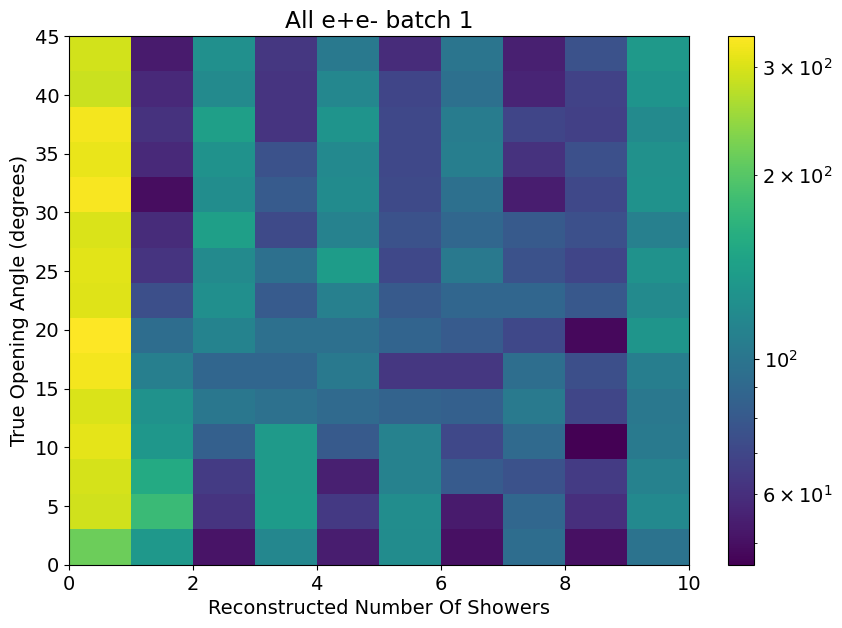

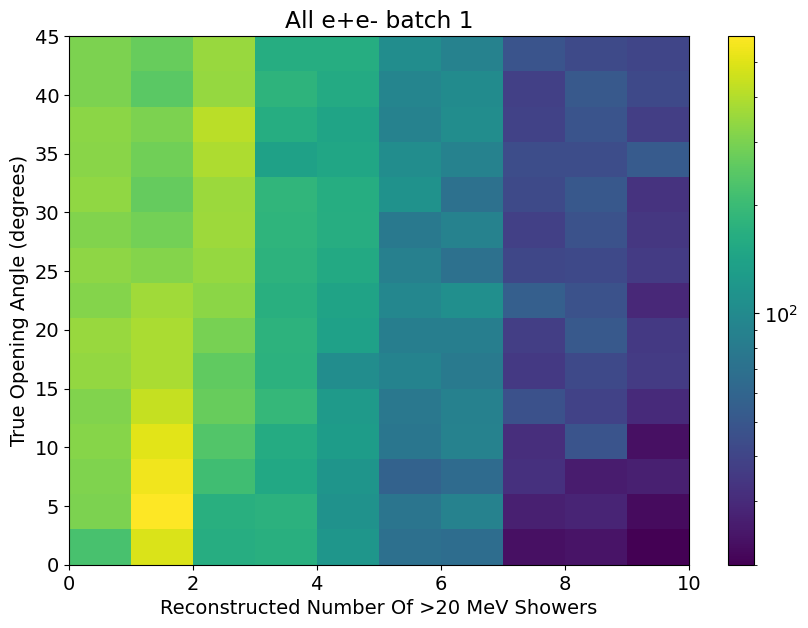

In [18]:
xlabel = "Reco Opening Angle\nFrom Two Highest Energy Showers (degrees)"
ylabel = "True Opening Angle (degrees)"
x_var = "reco_two_leading_showers_opening_angle"
y_var = "true_opening_angle"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
x_bin_edges = np.linspace(-10., 180., 19)
y_bin_edges = np.linspace(0., 45., 15)
bins = (x_bin_edges, y_bin_edges)

plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(x, y, bins=bins, norm=mpl.colors.LogNorm())
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.title("All e+e- batch 1")
plt.savefig(f"plots/true_vs_reco_opening_angle.png")



xlabel = "Reco Opening Angle\nFrom Two Highest Energy Showers (degrees)"
ylabel = "True Opening Angle (degrees)"
x_var = "reco_two_leading_showers_opening_angle"
y_var = "true_opening_angle"

x = all_df.query("num_reco_showers > 1")[x_var].to_numpy()
y = all_df.query("num_reco_showers > 1")[y_var].to_numpy()
x_bin_edges = np.linspace(-10., 180., 19)
y_bin_edges = np.linspace(0., 45., 15)
bins = (x_bin_edges, y_bin_edges)

plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(x, y, bins=bins, norm=mpl.colors.LogNorm())
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.title("All e+e- batch 1 with > 1 reco shower")


xlabel = "Reconstructed Number Of Showers"
ylabel = "True Opening Angle (degrees)"
x_var = "num_reco_showers"
y_var = "true_opening_angle"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
x_bin_edges = np.linspace(0, 10, 11)
y_bin_edges = np.linspace(0., 45., 16)
bins = (x_bin_edges, y_bin_edges)

plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(x, y, bins=bins, norm=mpl.colors.LogNorm())
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.title("All e+e- batch 1")


xlabel = "Reconstructed Number Of >20 MeV Showers"
ylabel = "True Opening Angle (degrees)"
x_var = "num_reco_greater_than_20_MeV_showers"
y_var = "true_opening_angle"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
x_bin_edges = np.linspace(0, 10, 11)
y_bin_edges = np.linspace(0., 45., 16)
bins = (x_bin_edges, y_bin_edges)

plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(x, y, bins=bins, norm=mpl.colors.LogNorm())
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.title("All e+e- batch 1")



In [19]:
train_vars = all_numu_scalars[:-2] + all_nue_scalars + numu_bdt_score_variables + nue_bdt_score_variables + kine_scalar_vars

model = xgb.XGBClassifier()
model.load_model("../NC_bdt_stuff/models/NC_Delta_prev_training_plus_even_subrun_ncpi0_ncdelta.model")

x = all_df[train_vars].to_numpy()
xgb_score = model.predict_proba(x)[:,1]
tvma_score = [math.tanh(_) for _ in xgb_score]
transformed_tvma_score = [math.log10((1. + _) / (1. - _)) for _ in tvma_score]
all_df["nc_delta_score"] = transformed_tvma_score


"""# calculating numu scores again to test BDT variables

model_scalars_scores = xgb.XGBClassifier()
model_scalars_scores.load_model("../NC_bdt_stuff/models/numu_final.model")
x_scalars_scores = all_df[all_numu_scalars + numu_bdt_score_variables].to_numpy()
#x_scalars_scores = all_df[numu_bdt_score_variables + all_numu_scalars].to_numpy() # this line is wrong
xgb_score = model_scalars_scores.predict_proba(x_scalars_scores)[:,1]
tvma_score = [math.tanh(_) for _ in xgb_score]
transformed_tvma_score = [math.log10((1. + _) / (1. - _)) for _ in tvma_score]
all_df["numu_score_recalculated"] = transformed_tvma_score"""

'# calculating numu scores again to test BDT variables\n\nmodel_scalars_scores = xgb.XGBClassifier()\nmodel_scalars_scores.load_model("../NC_bdt_stuff/models/numu_final.model")\nx_scalars_scores = all_df[all_numu_scalars + numu_bdt_score_variables].to_numpy()\n#x_scalars_scores = all_df[numu_bdt_score_variables + all_numu_scalars].to_numpy() # this line is wrong\nxgb_score = model_scalars_scores.predict_proba(x_scalars_scores)[:,1]\ntvma_score = [math.tanh(_) for _ in xgb_score]\ntransformed_tvma_score = [math.log10((1. + _) / (1. - _)) for _ in tvma_score]\nall_df["numu_score_recalculated"] = transformed_tvma_score'

In [20]:
mpl.rcParams.update({'font.size': 20})

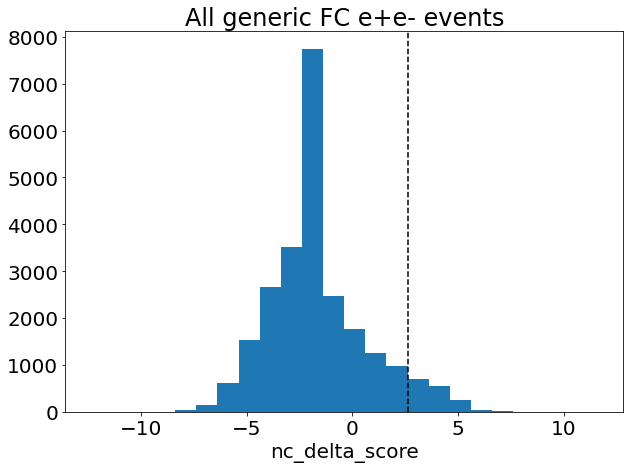

In [21]:
bin_edges = [i - 15 + 2.61 for i in range(25)]

plt.figure(figsize=(10,7))
plt.hist(all_df["nc_delta_score"].to_numpy(), bins=bin_edges)
plt.xlabel("nc_delta_score")
plt.axvline(2.61, c="black", linestyle="dashed")
plt.title("All generic FC e+e- events")
plt.savefig(f"plots/nc_delta_score.png")
plt.show()

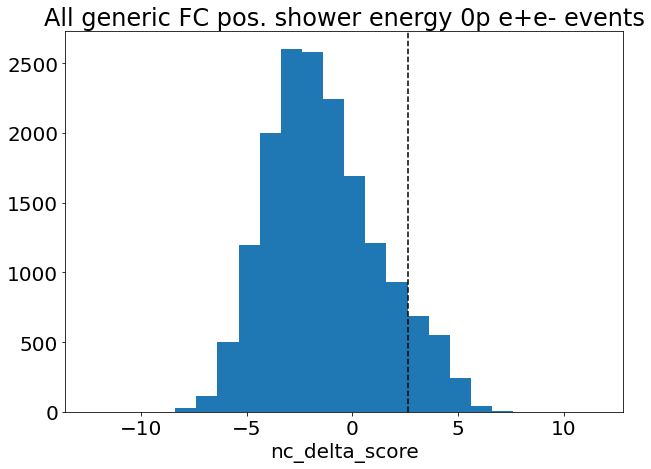

In [22]:
bin_edges = [i - 15 + 2.61 for i in range(25)]

nc_delta_presel = all_df.query("reco_showerKE > 0 and num_protons==0")

plt.figure(figsize=(10,7))
plt.hist(nc_delta_presel["nc_delta_score"].to_numpy(), bins=bin_edges)
plt.xlabel("nc_delta_score")
plt.axvline(2.61, c="black", linestyle="dashed")
plt.title("All generic FC pos. shower energy 0p e+e- events")
plt.savefig(f"plots/nc_delta_score_presel.png")

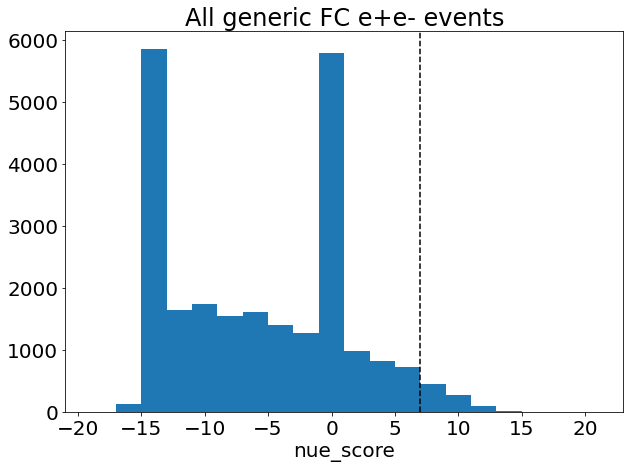

In [23]:
bin_edges = [-19 + 2*i for i in range(21)]

plt.figure(figsize=(10,7))
plt.hist(all_df["nue_score"].to_numpy(), bins=bin_edges)
plt.axvline(7, c="black", linestyle="dashed")
plt.xlabel("nue_score")
plt.title("All generic FC e+e- events")
plt.savefig(f"plots/nue_score.png")
plt.show()

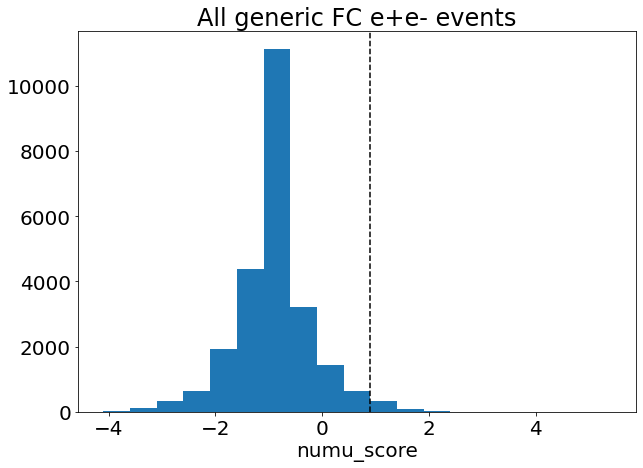

In [24]:
bin_edges = [-5 + 0.9 + 0.5 * i for i in range(20)]

plt.figure(figsize=(10,7))
plt.hist(all_df["numu_score"].to_numpy(), bins=bin_edges)
plt.axvline(0.9, c="black", linestyle="dashed")
plt.xlabel("numu_score")
plt.title("All generic FC e+e- events")
plt.savefig(f"plots/numu_score.png")
plt.show()

In [25]:
num_total = all_df.shape[0]

num_selected_generic = all_df.query("kine_reco_Enu > 0").shape[0]
num_selected_generic_FC = all_df.query("kine_reco_Enu > 0 and match_isFC == 1").shape[0]
num_selected_1gXp = all_df.query("kine_reco_Enu > 0 and match_isFC == 1 and nc_delta_score > 2.61 and reco_showerKE > 0").shape[0]
num_selected_1g0p = all_df.query("kine_reco_Enu > 0 and match_isFC == 1 and nc_delta_score > 2.61 and reco_showerKE > 0 and num_protons==0").shape[0]
num_selected_1g0p0pi = all_df.query("kine_reco_Enu > 0 and match_isFC == 1 and nc_delta_score > 2.61 and reco_showerKE > 0 and num_protons==0 and num_other_tracks==0").shape[0]
num_selected_nueCC = all_df.query("kine_reco_Enu > 0 and nue_score > 7").shape[0]
num_selected_nueCC_FC = all_df.query("kine_reco_Enu > 0 and match_isFC == 1 and nue_score > 7").shape[0]


print("Overall Efficiencies:")
print("\nWC generic: ", num_selected_generic / num_total)
print("WC generic FC: ", num_selected_generic_FC / num_total)
print("\nWC NC Delta 1gXp: ", num_selected_1gXp / num_total)
print("WC NC Delta 1g0p: ", num_selected_1g0p / num_total)
print("WC NC Delta 1g0p0pi: ", num_selected_1g0p0pi / num_total)
print("\nWC nueCC: ", num_selected_nueCC / num_total)
print("WC nueCC FC: ", num_selected_nueCC_FC / num_total)

Overall Efficiencies:

WC generic:  0.8071063899868248
WC generic FC:  0.6584733201581028

WC NC Delta 1gXp:  0.05389492753623189
WC NC Delta 1g0p:  0.05265974967061923
WC NC Delta 1g0p0pi:  0.04969532279314888

WC nueCC:  0.033885046113306984
WC nueCC FC:  0.029397233201581028


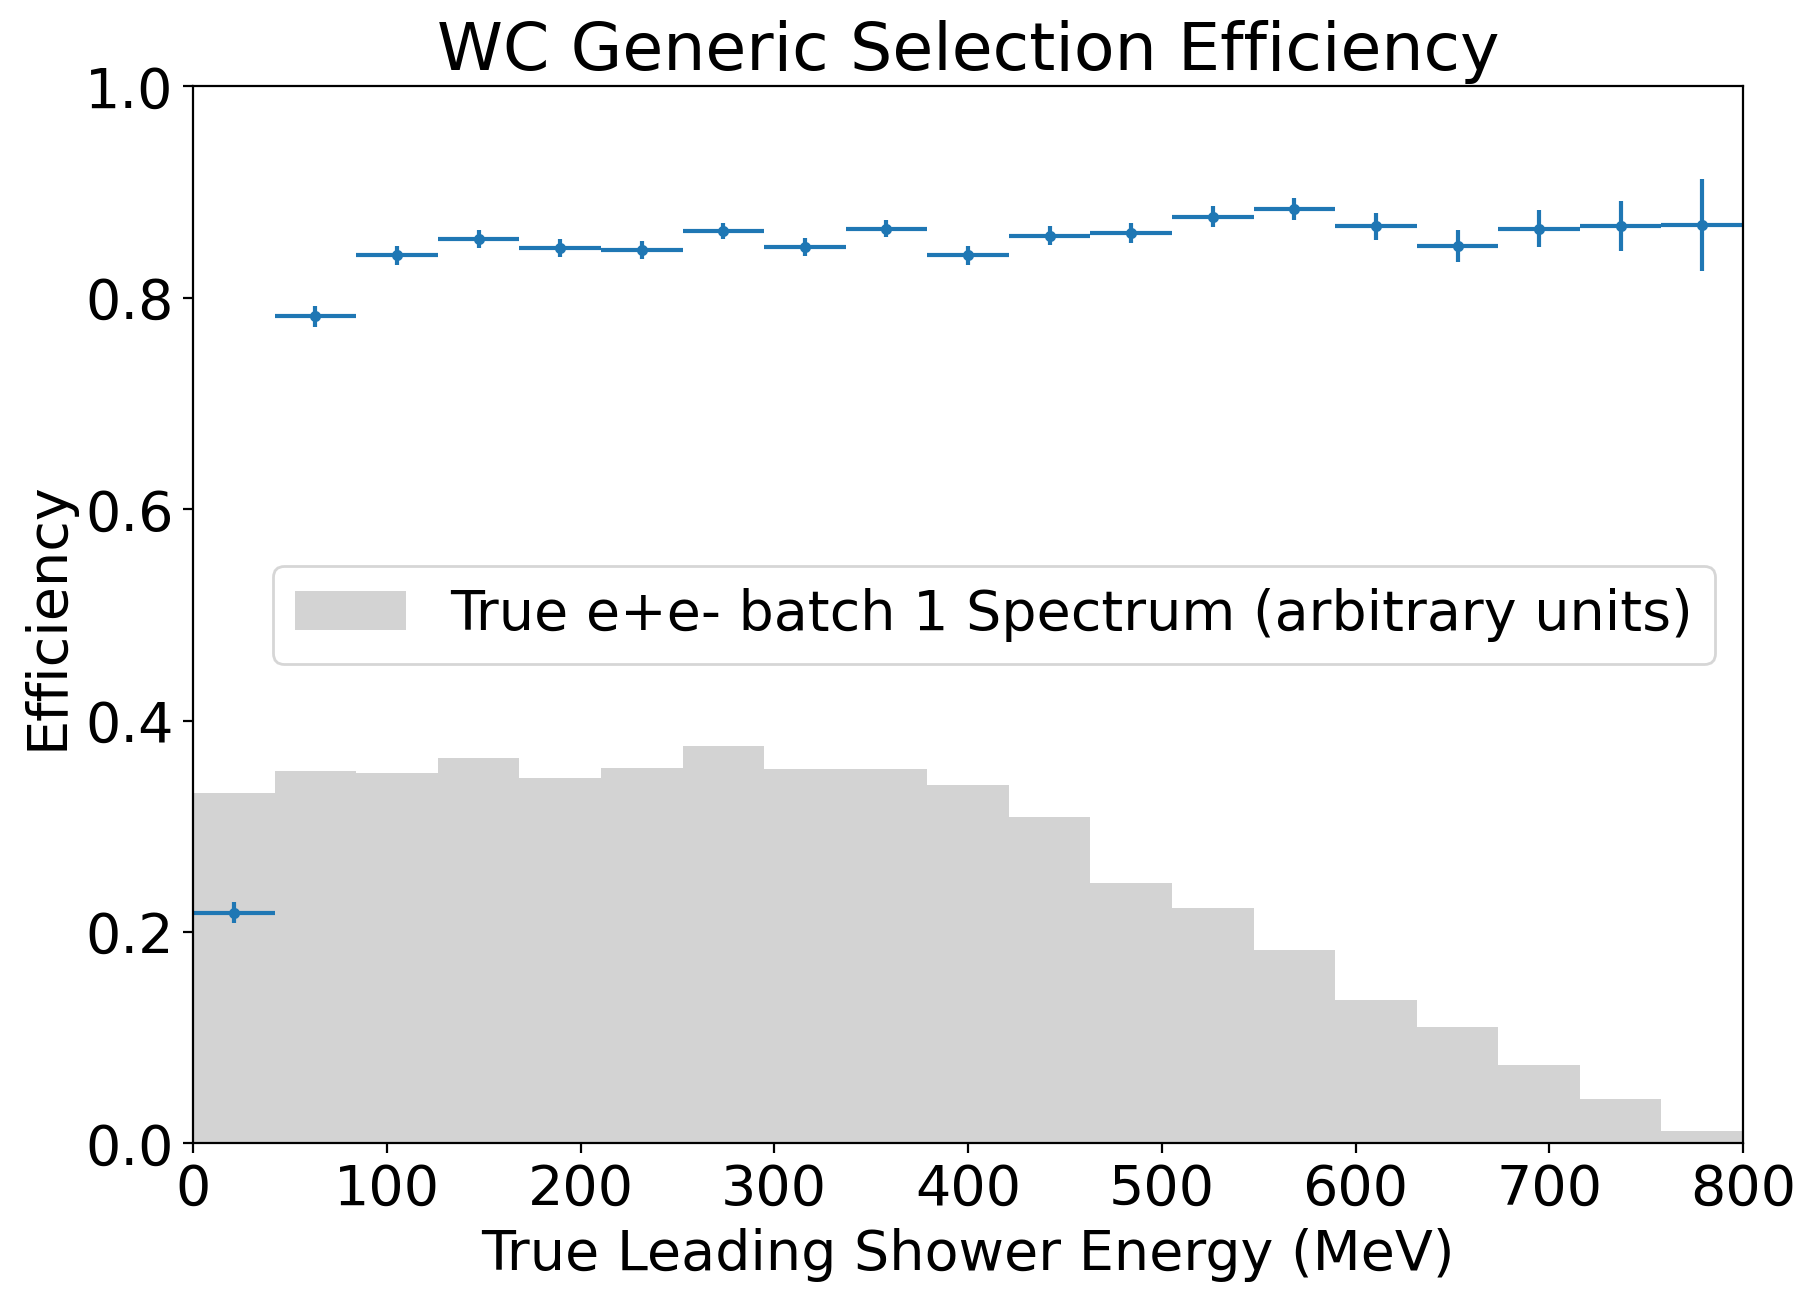

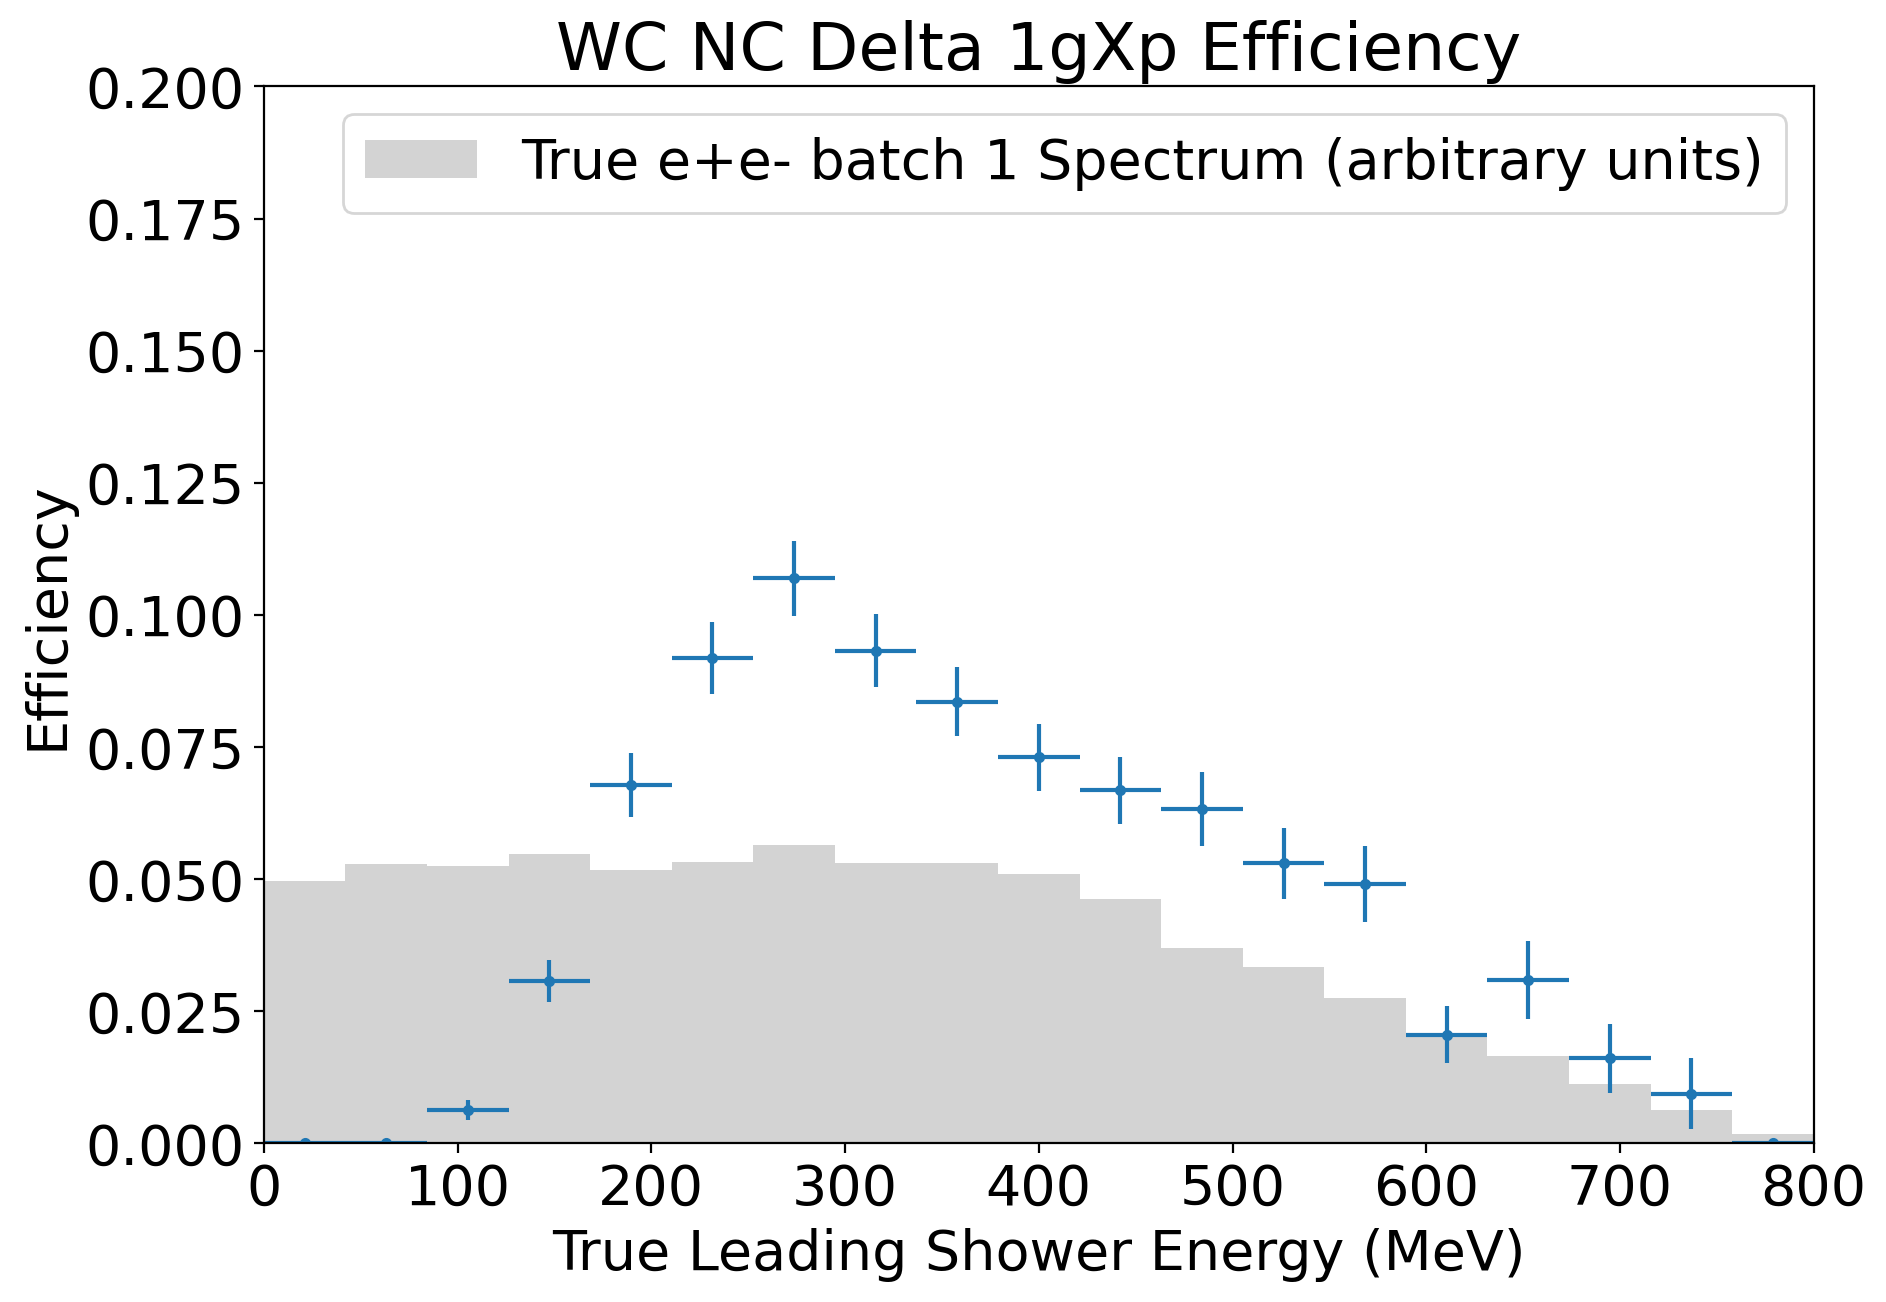

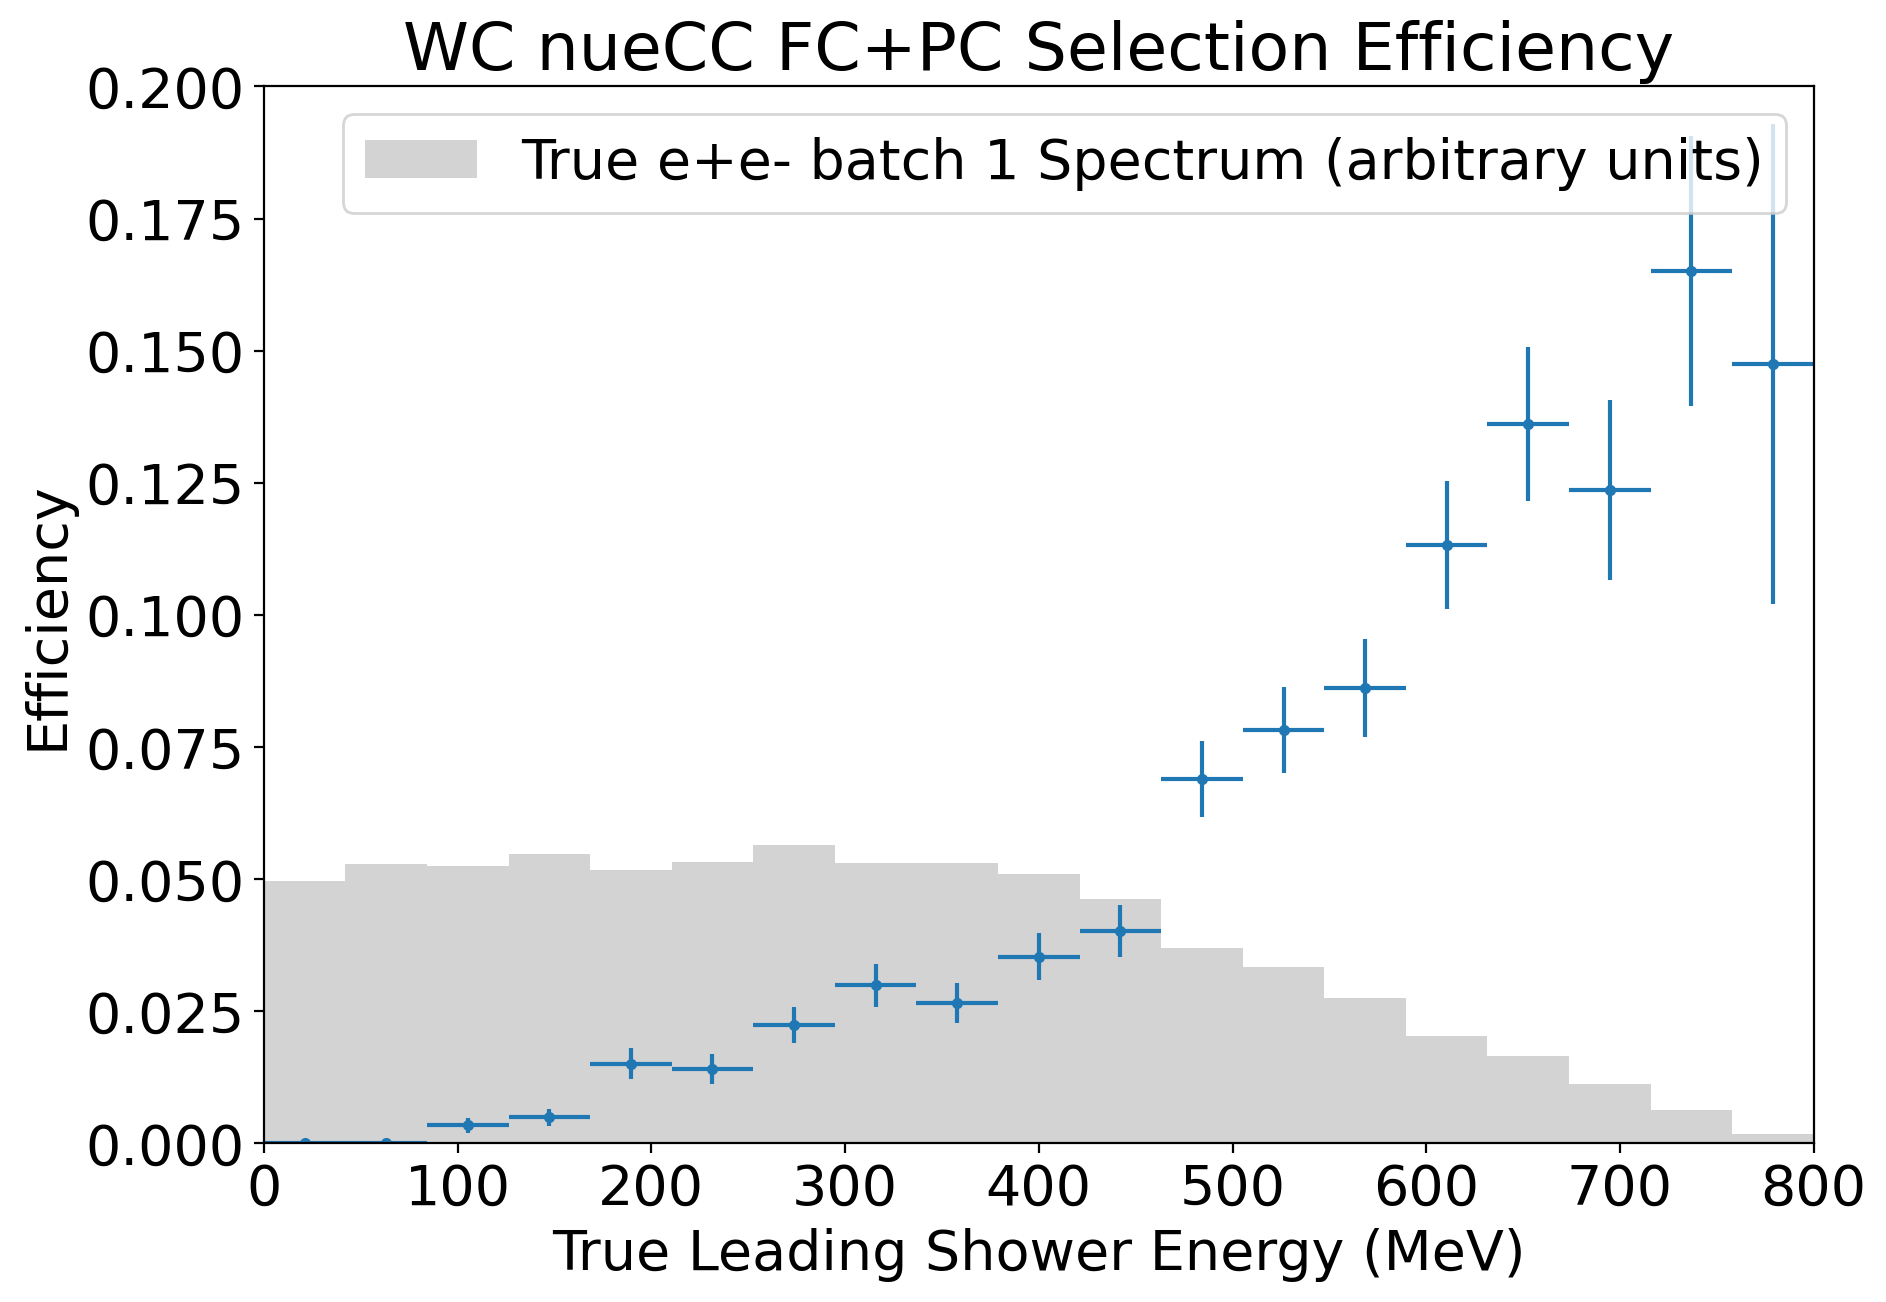

In [26]:
# 1D efficiencies by energy

sel_query = "kine_reco_Enu > 0"
title = "WC Generic Selection Efficiency"
filename = "eff_shower_energy_generic"

bins = np.linspace(0., 800., 20)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_leading_shower_energy"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_leading_shower_energy"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_leading_shower_energy"].to_numpy(), bins=bins, weights=[0.0002 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Leading Shower Energy (MeV)")
plt.ylabel("Efficiency")
plt.xlim(0., 800.)
plt.ylim(0., 1.)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")



sel_query = "match_isFC==1 and kine_reco_Enu > 0 and nc_delta_score > 2.61 and reco_showerKE > 0"
title = "WC NC Delta 1gXp Efficiency"
filename = "eff_shower_energy_1gXp"

bins = np.linspace(0., 800., 20)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_leading_shower_energy"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_leading_shower_energy"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_leading_shower_energy"].to_numpy(), bins=bins, weights=[0.00003 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Leading Shower Energy (MeV)")
plt.ylabel("Efficiency")
plt.xlim(0., 800.)
plt.ylim(0., 0.2)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")


sel_query = "kine_reco_Enu > 0 and nue_score > 7"
title = "WC nueCC FC+PC Selection Efficiency"
filename = "eff_shower_energy_nueCC"

bins = np.linspace(0., 800., 20)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_leading_shower_energy"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_leading_shower_energy"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_leading_shower_energy"].to_numpy(), bins=bins, weights=[0.00003 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Leading Shower Energy (MeV)")
plt.ylabel("Efficiency")
plt.xlim(0., 800.)
plt.ylim(0., 0.2)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")


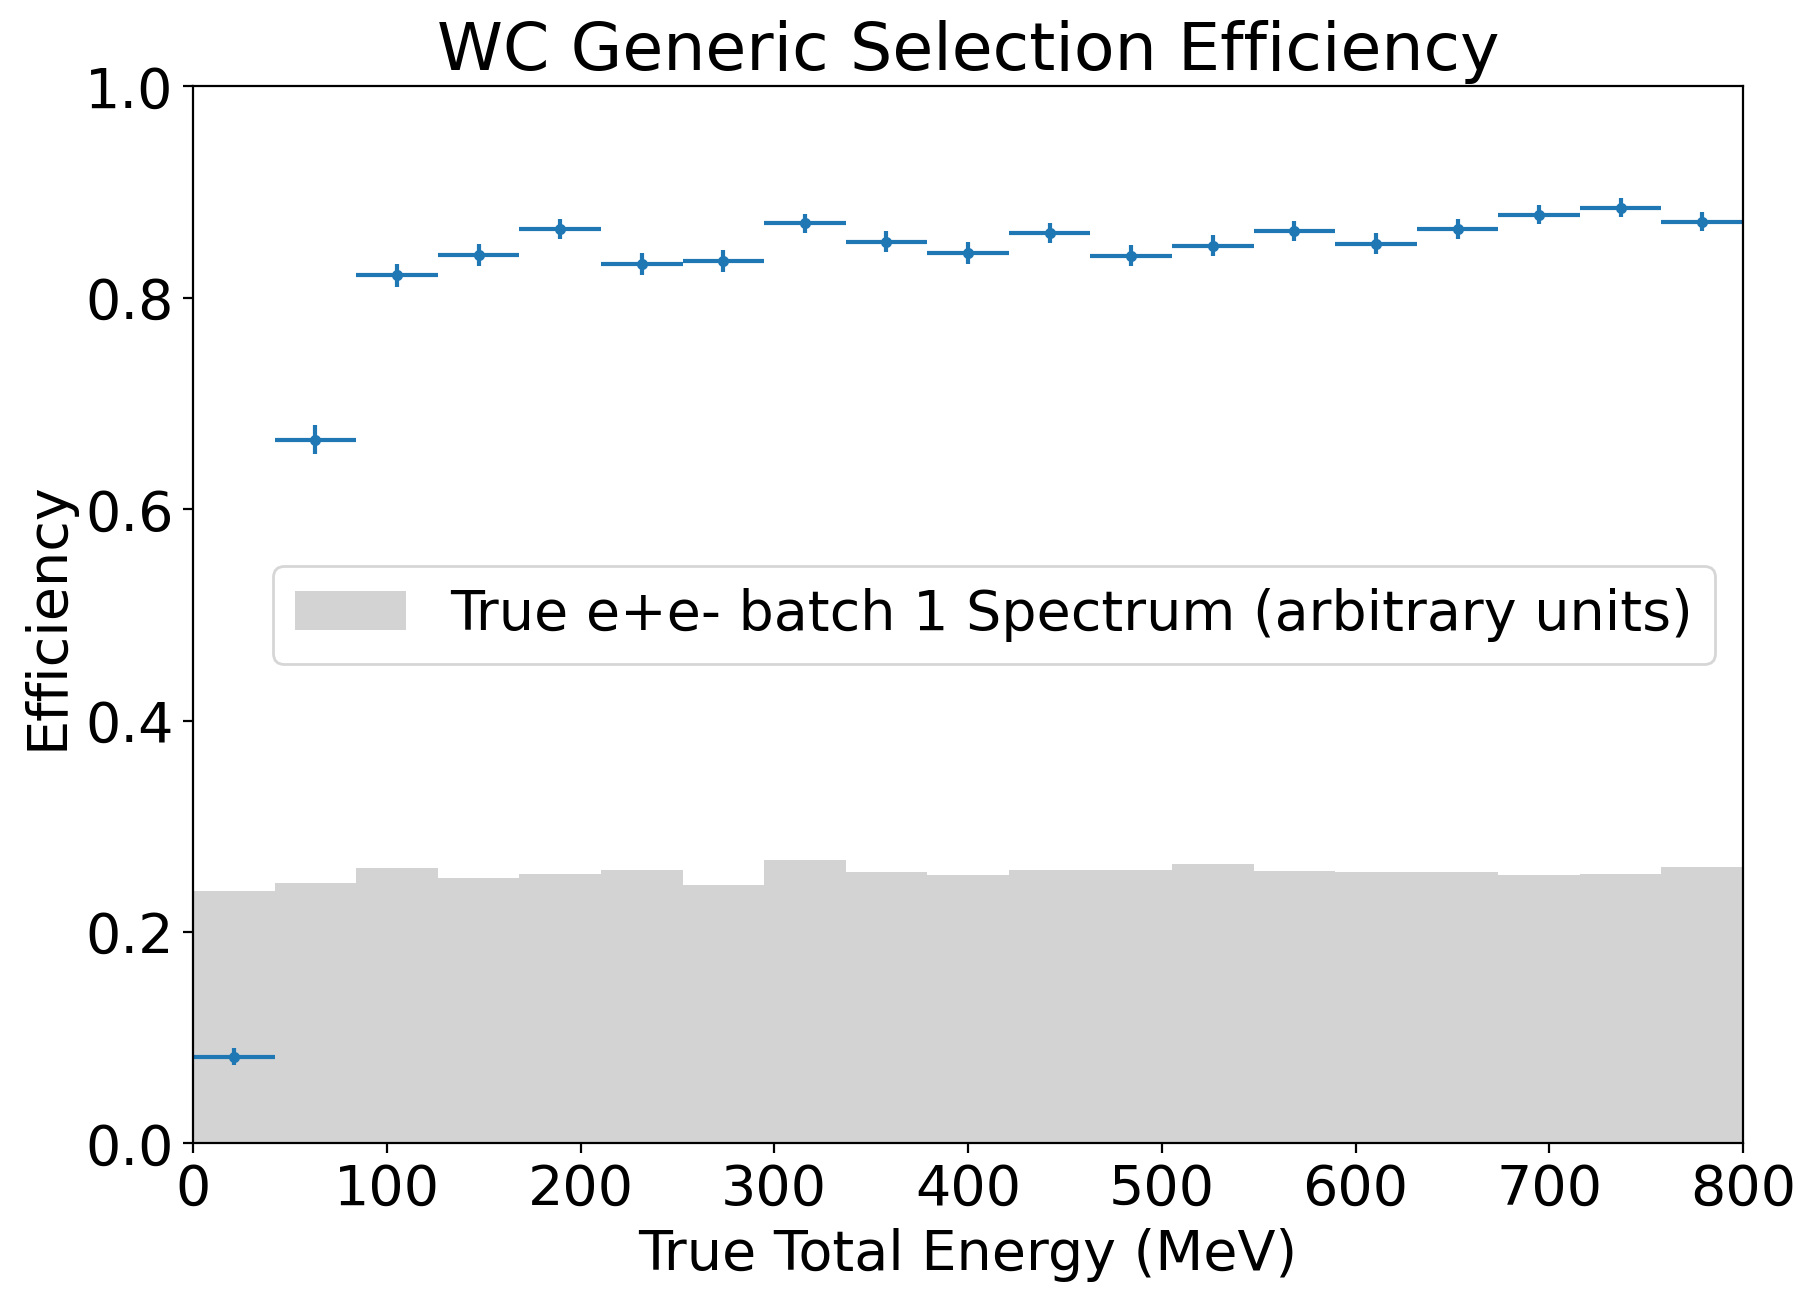

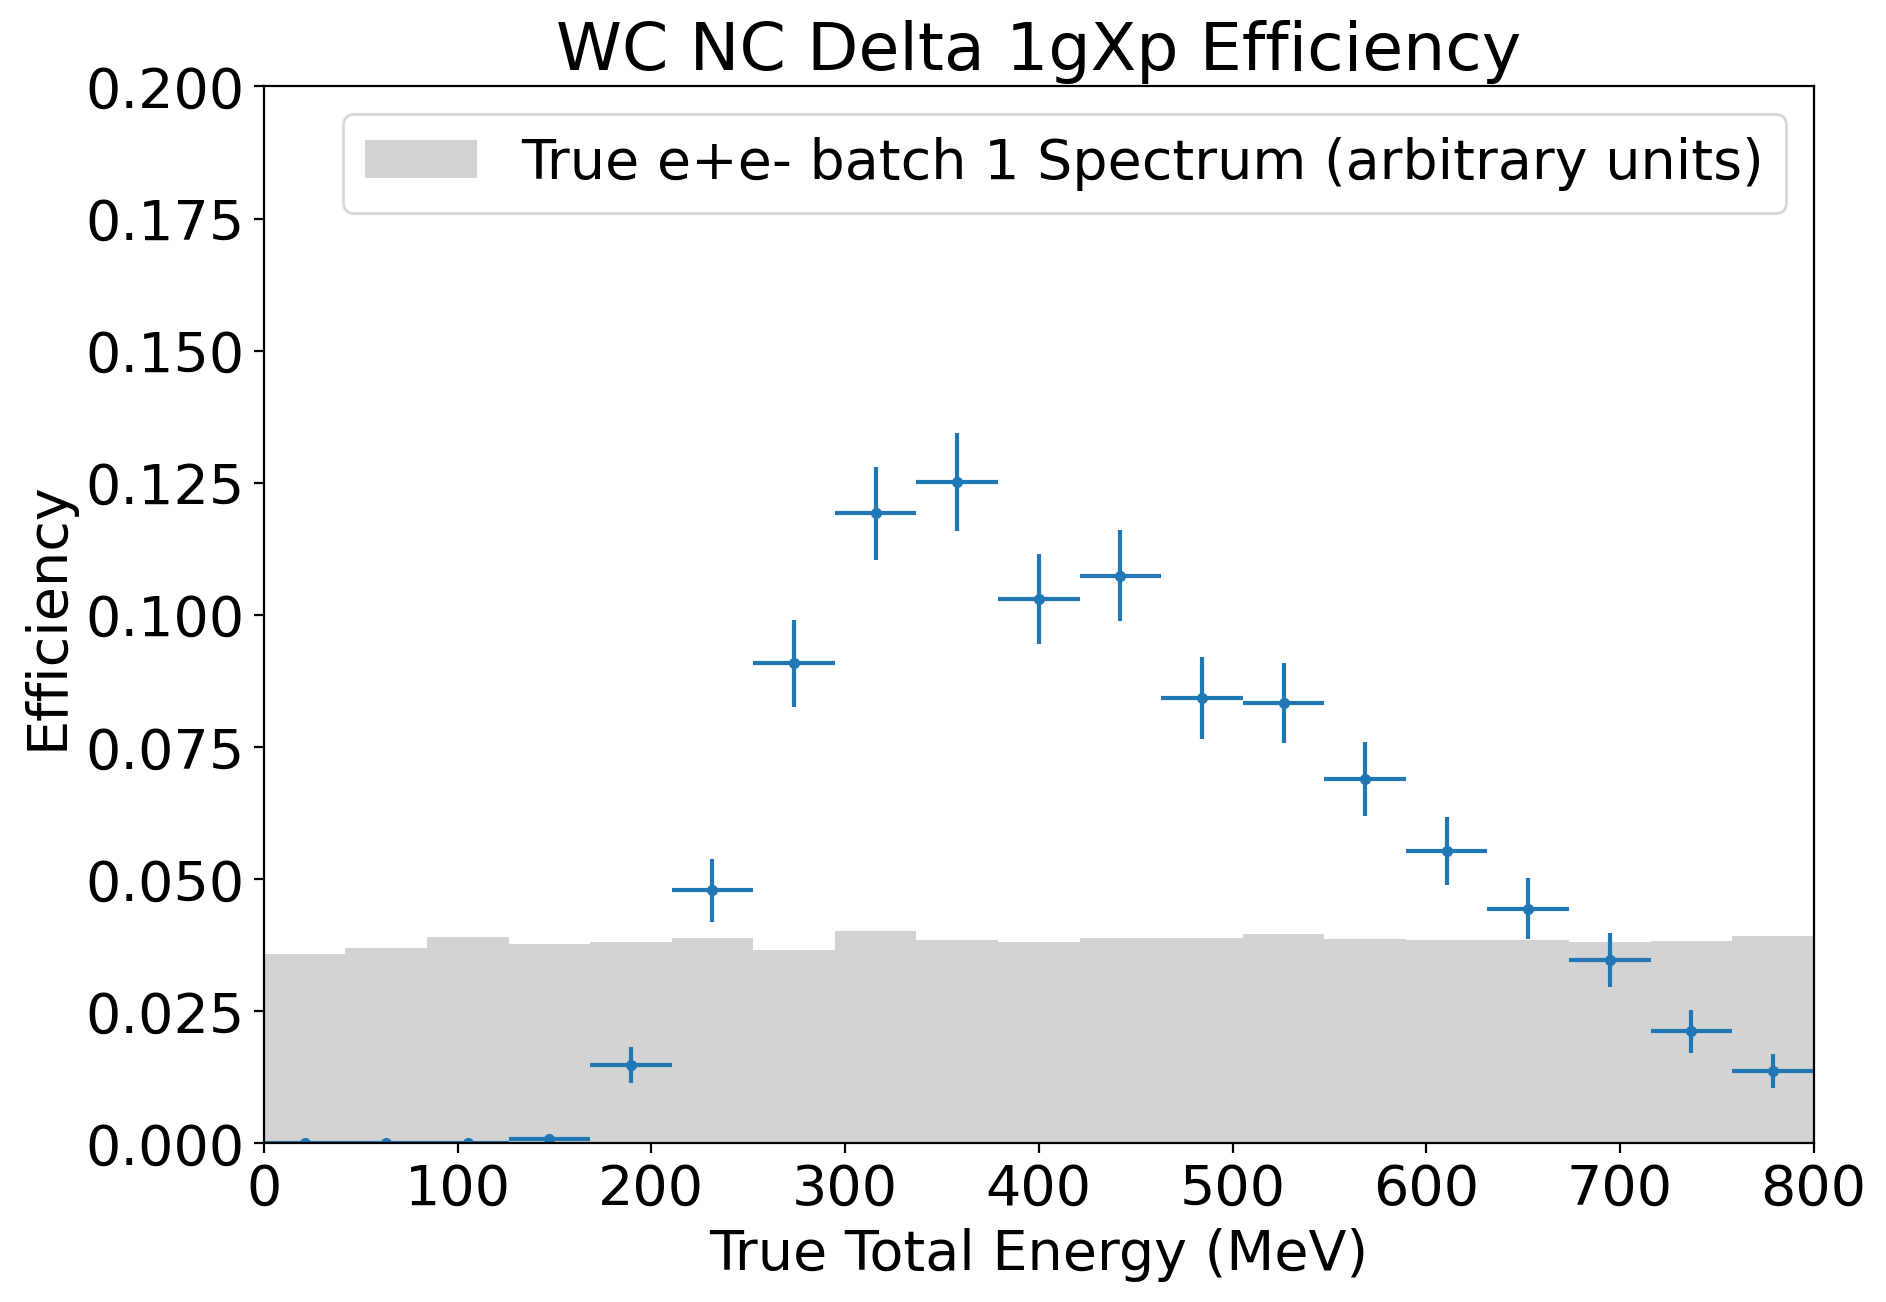

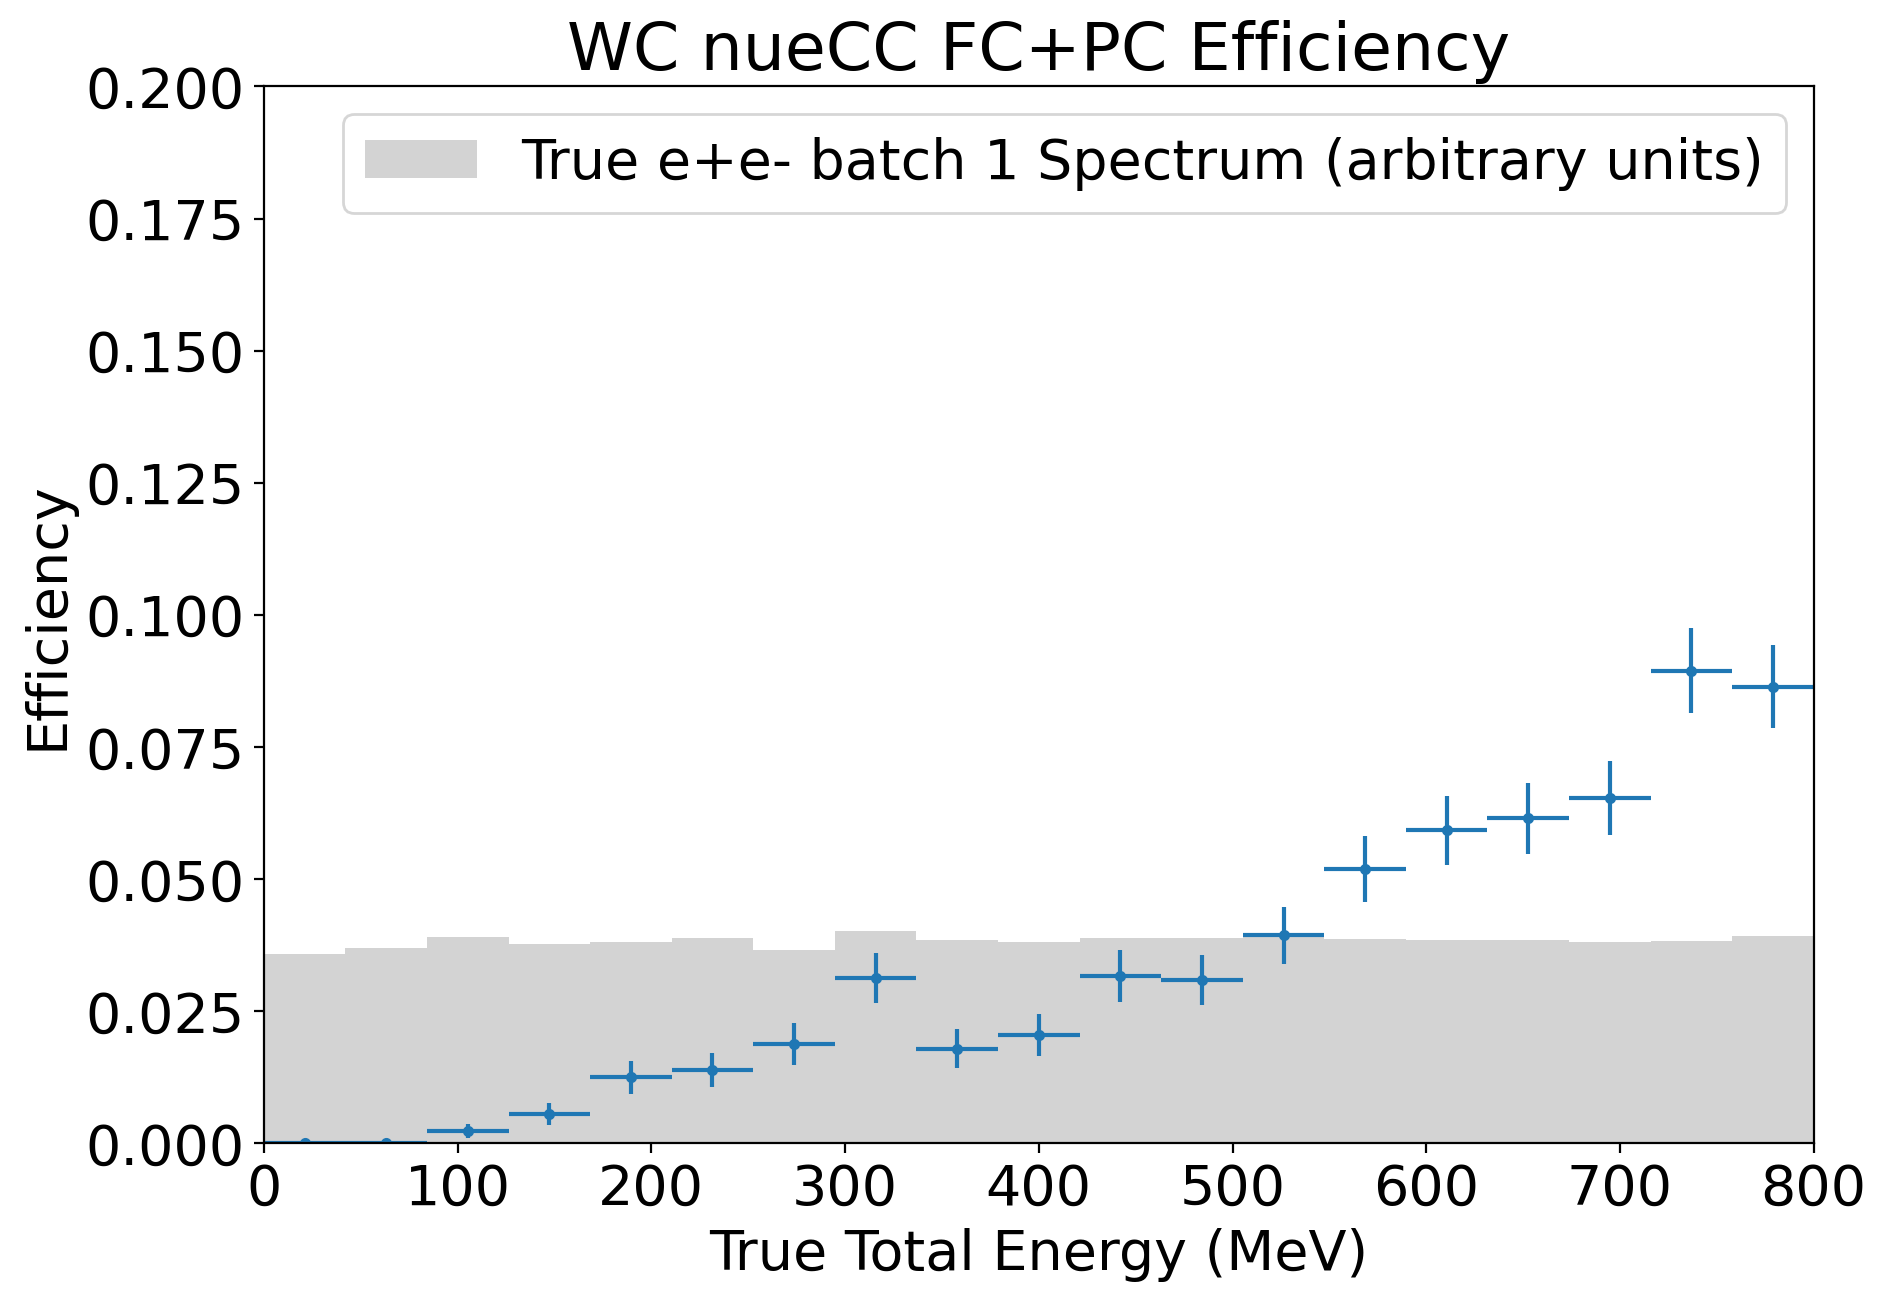

In [27]:
# 1D efficiencies by energy

sel_query = "kine_reco_Enu > 0"
title = "WC Generic Selection Efficiency"
filename = "eff_total_energy_generic"

bins = np.linspace(0., 800., 20)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_total_energy"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_total_energy"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_total_energy"].to_numpy(), bins=bins, weights=[0.0002 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Total Energy (MeV)")
plt.ylabel("Efficiency")
plt.xlim(0., 800.)
plt.ylim(0., 1.)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")



sel_query = "match_isFC==1 and kine_reco_Enu > 0 and nc_delta_score > 2.61 and reco_showerKE > 0"
title = "WC NC Delta 1gXp Efficiency"
filename = "eff_total_energy_1gXp"

bins = np.linspace(0., 800., 20)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_total_energy"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_total_energy"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_total_energy"].to_numpy(), bins=bins, weights=[0.00003 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Total Energy (MeV)")
plt.ylabel("Efficiency")
plt.xlim(0., 800.)
plt.ylim(0., 0.2)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")


sel_query = "kine_reco_Enu > 0 and nue_score > 7"
title = "WC nueCC FC+PC Efficiency"
filename = "eff_total_energy_nueCC"

bins = np.linspace(0., 800., 20)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_total_energy"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_total_energy"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_total_energy"].to_numpy(), bins=bins, weights=[0.00003 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Total Energy (MeV)")
plt.ylabel("Efficiency")
plt.xlim(0., 800.)
plt.ylim(0., 0.2)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")

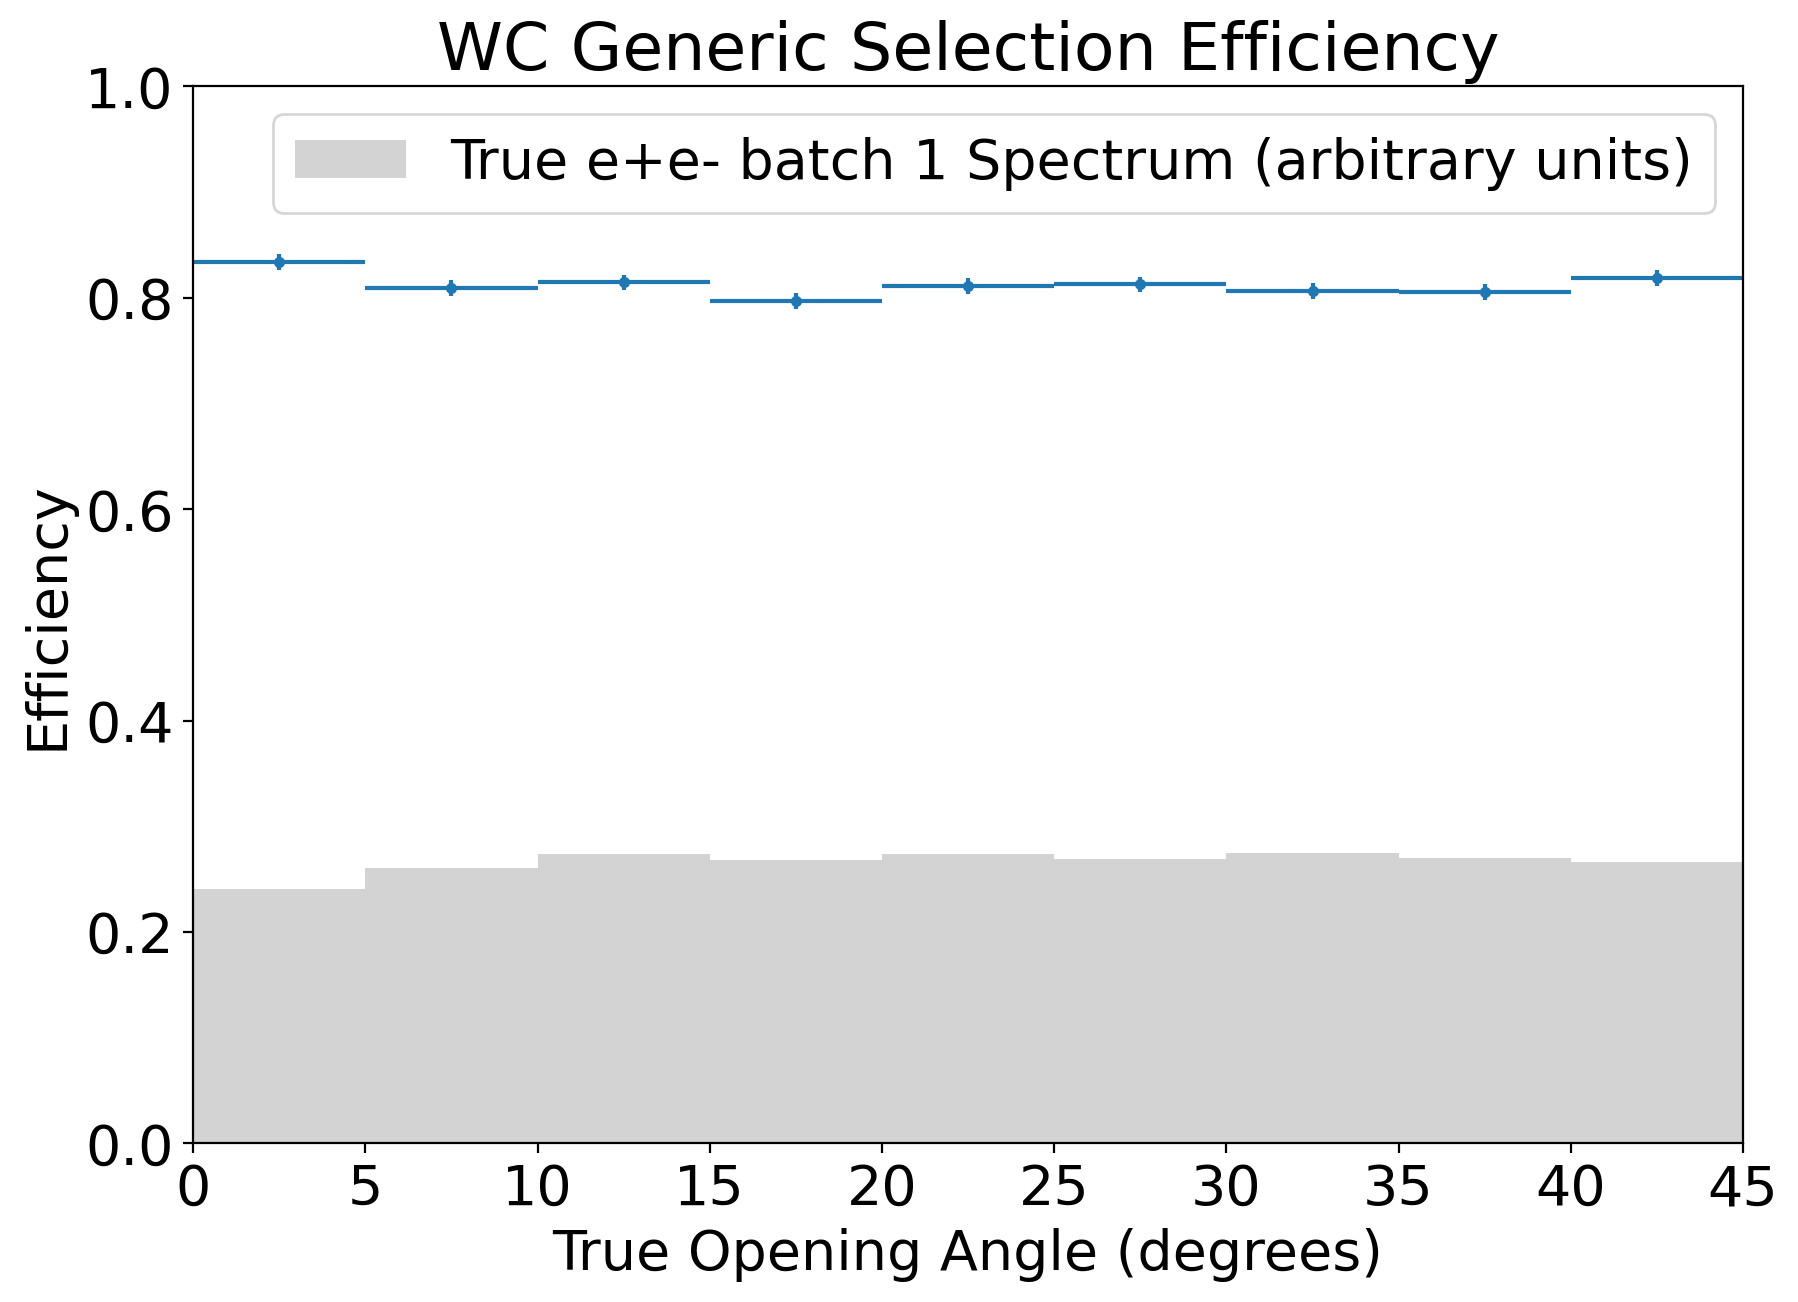

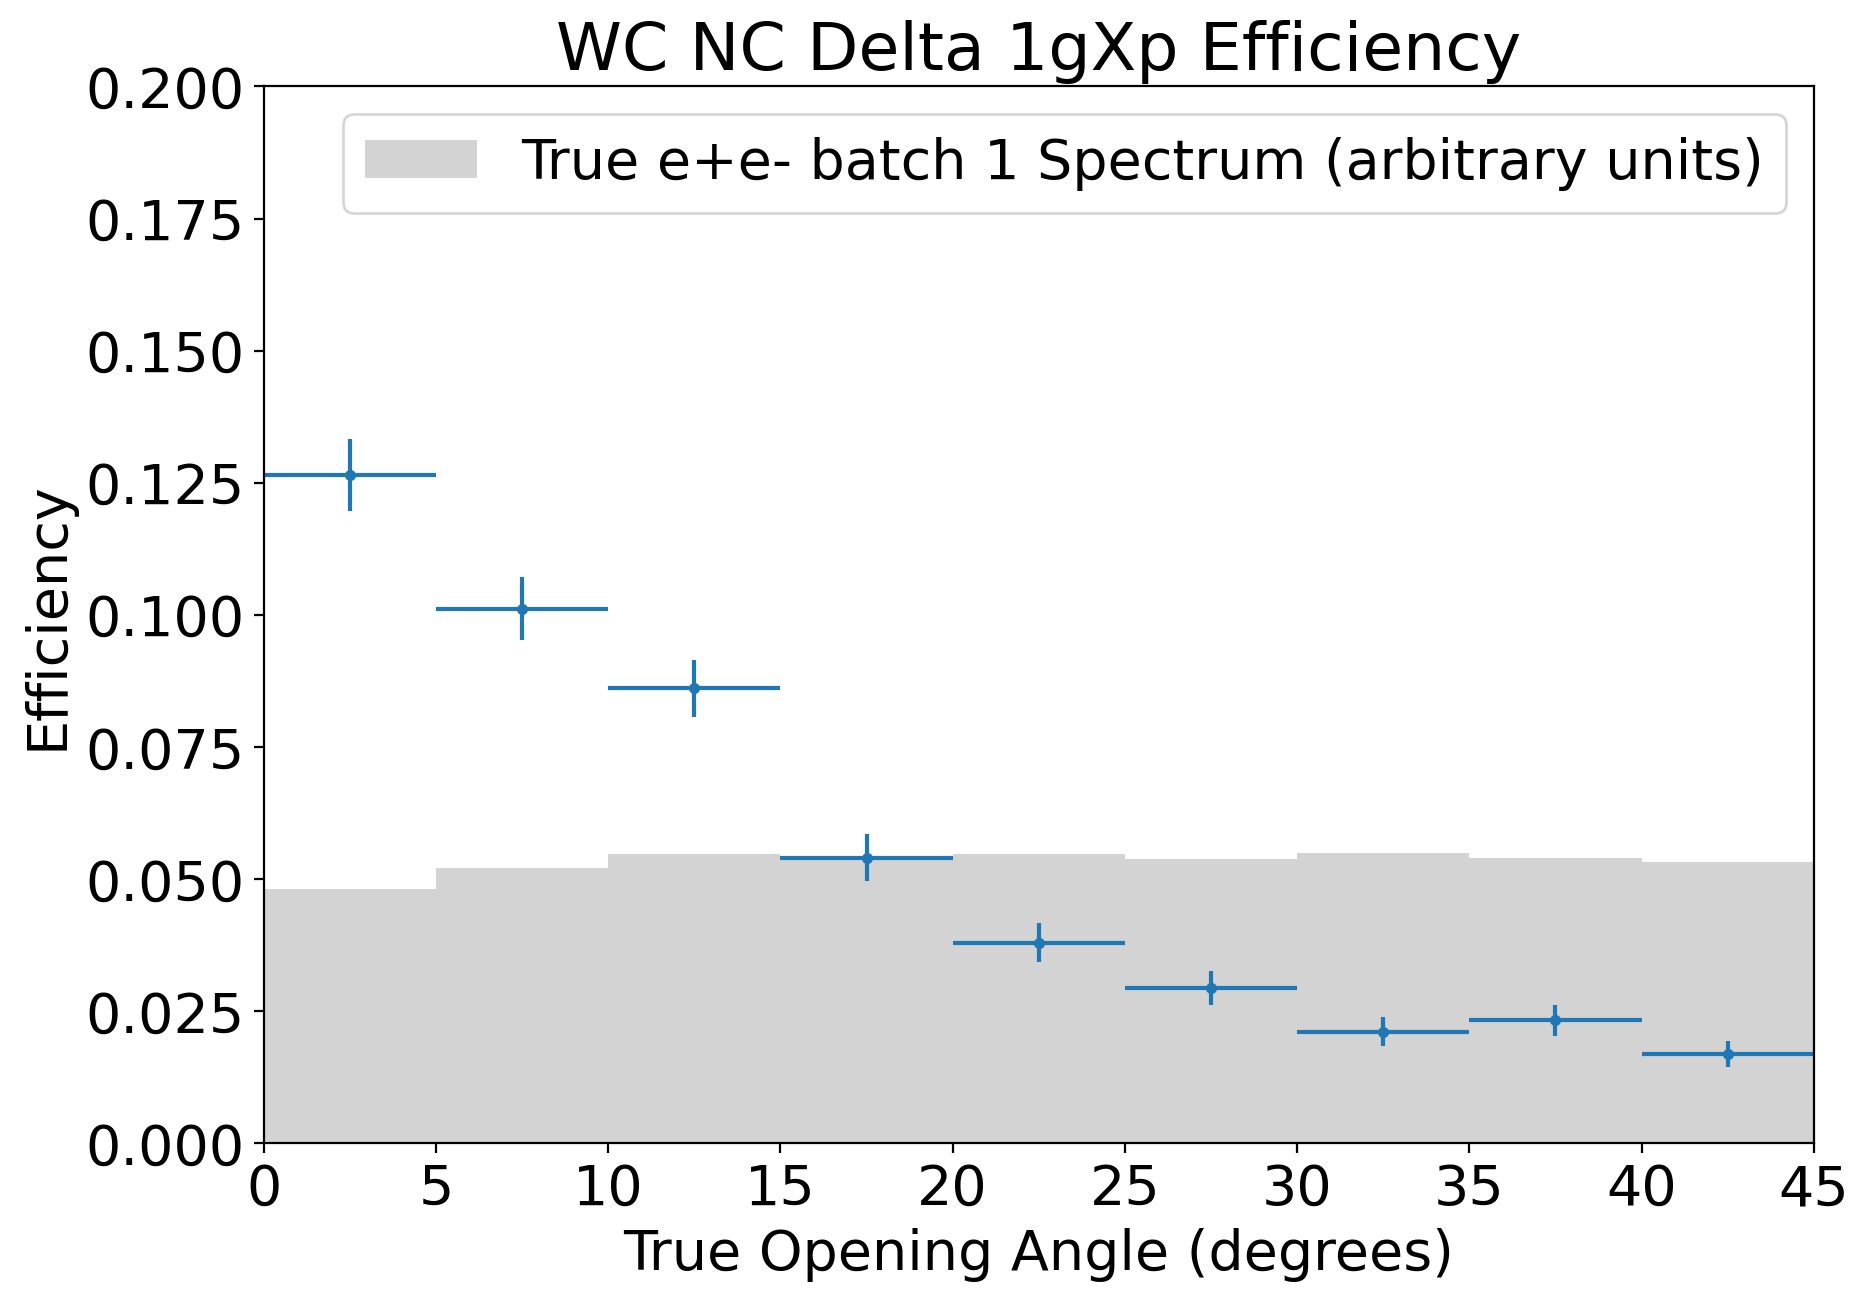

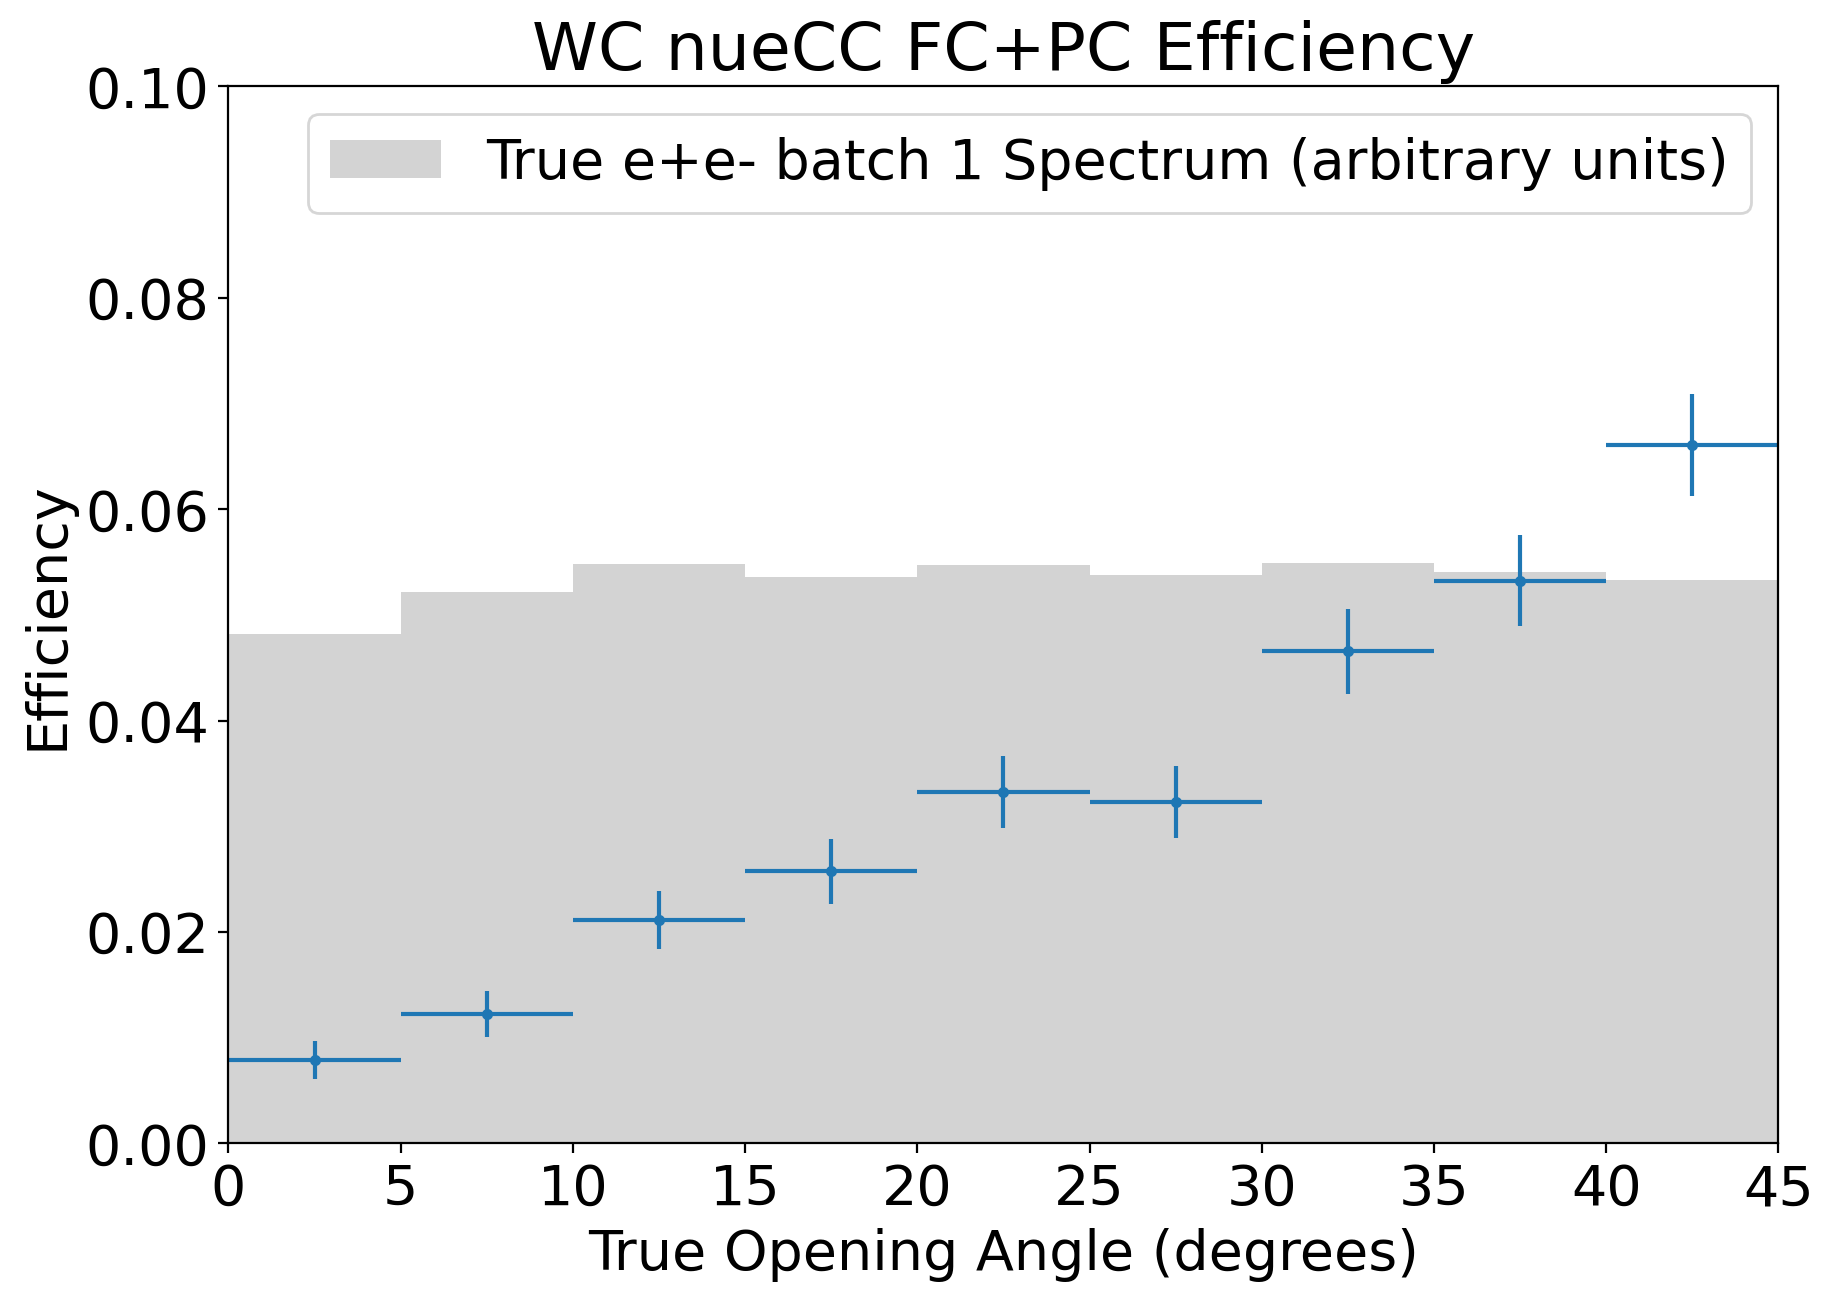

In [28]:
# 1D efficiencies by opening angle

sel_query = "kine_reco_Enu > 0"
title = "WC Generic Selection Efficiency"
filename = "eff_opening_angle_generic"

bins = np.linspace(0., 45., 10)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_opening_angle"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_opening_angle"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_opening_angle"].to_numpy(), bins=bins, weights=[0.0001 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Opening Angle (degrees)")
plt.ylabel("Efficiency")
plt.xlim(0., 45.)
plt.ylim(0., 1.)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")



sel_query = "match_isFC==1 and kine_reco_Enu > 0 and nc_delta_score > 2.61 and reco_showerKE > 0"
title = "WC NC Delta 1gXp Efficiency"
filename = "eff_opening_angle_1gXp"

bins = np.linspace(0., 45., 10)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_opening_angle"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_opening_angle"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_opening_angle"].to_numpy(), bins=bins, weights=[0.00002 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Opening Angle (degrees)")
plt.ylabel("Efficiency")
plt.xlim(0., 45.)
plt.ylim(0., 0.2)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")


sel_query = "kine_reco_Enu > 0 and nue_score > 7"
title = "WC nueCC FC+PC Efficiency"
filename = "eff_opening_angle_nueCC"

bins = np.linspace(0., 45., 10)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_opening_angle"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_opening_angle"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_opening_angle"].to_numpy(), bins=bins, weights=[0.00002 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Opening Angle (degrees)")
plt.ylabel("Efficiency")
plt.xlim(0., 45.)
plt.ylim(0., 0.1)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")


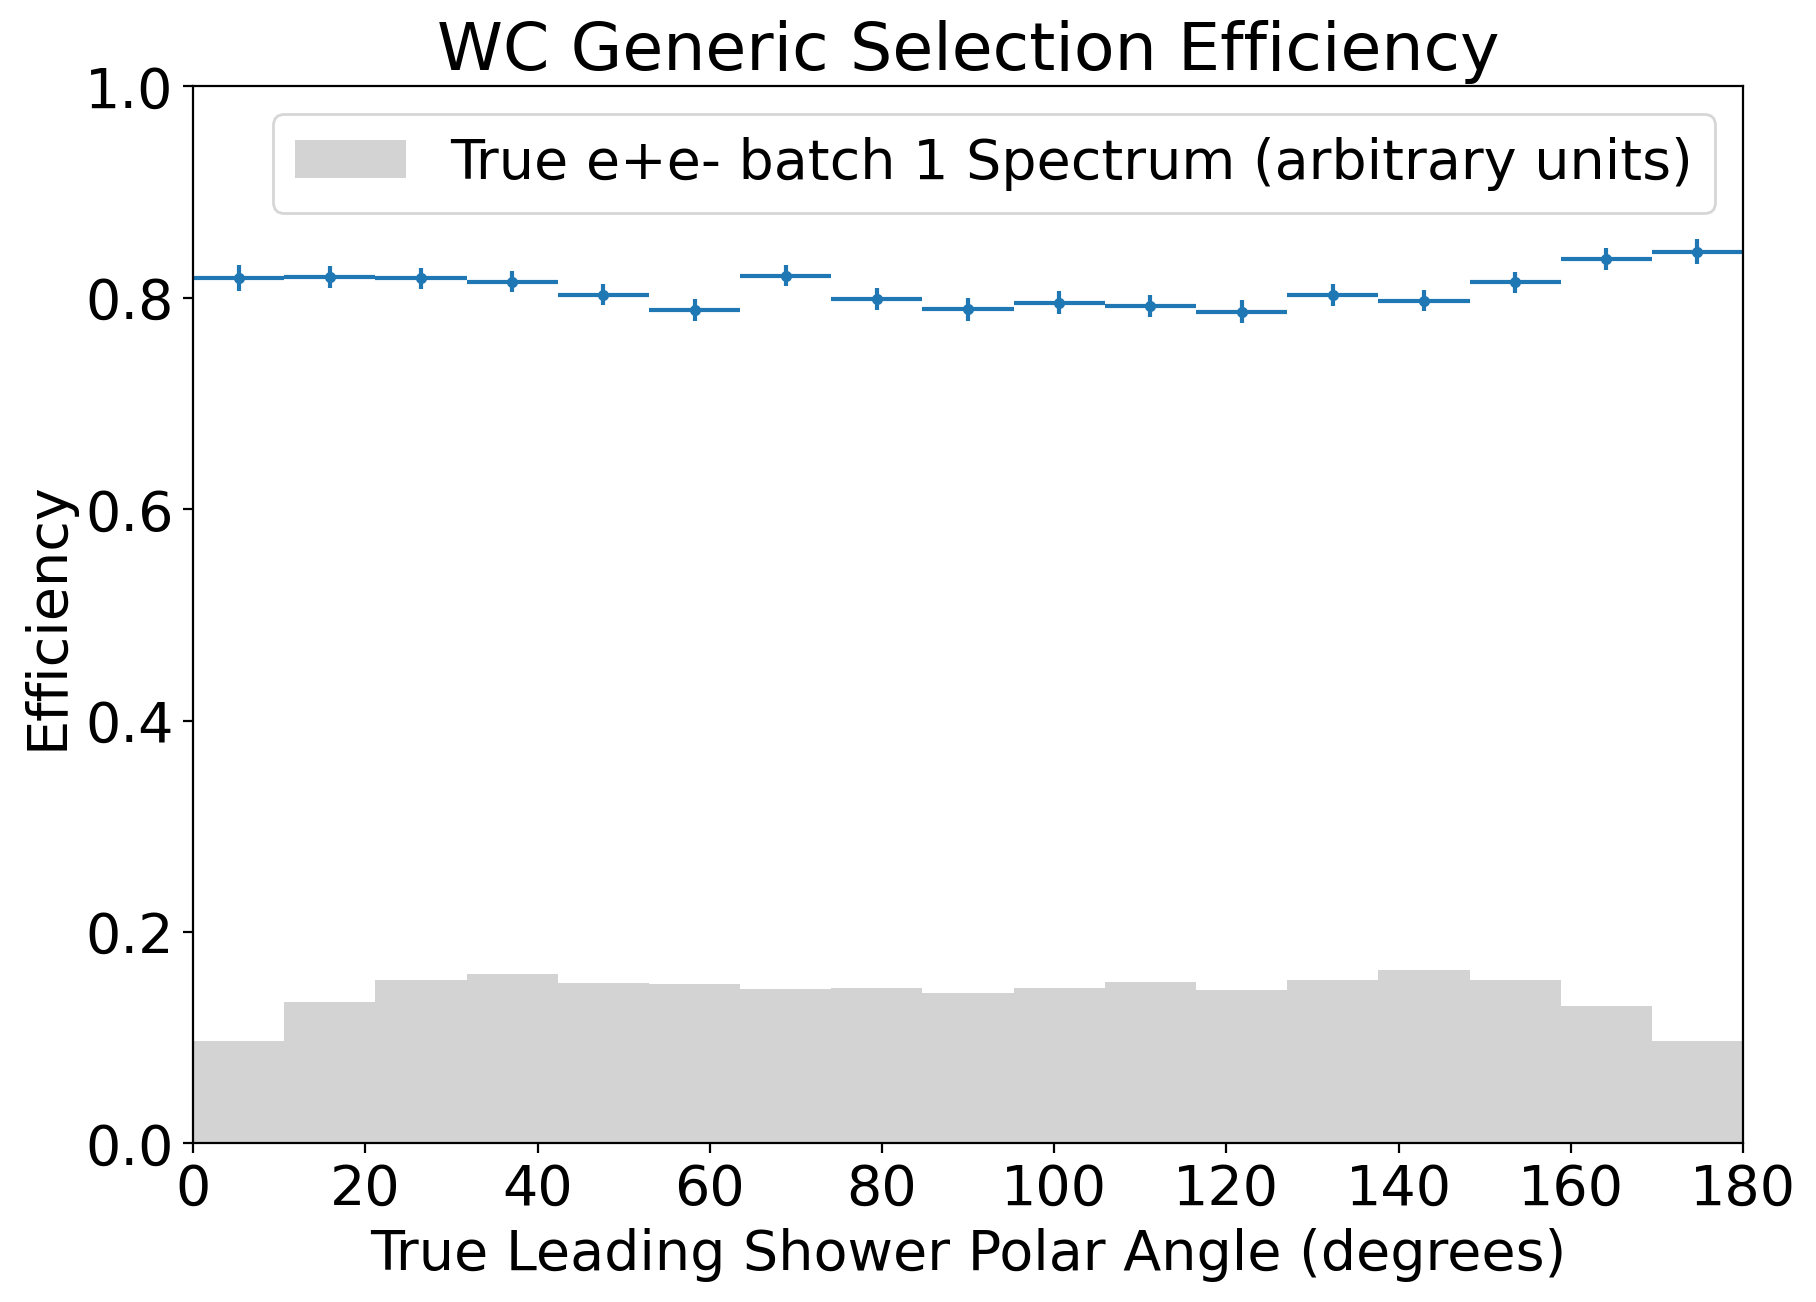

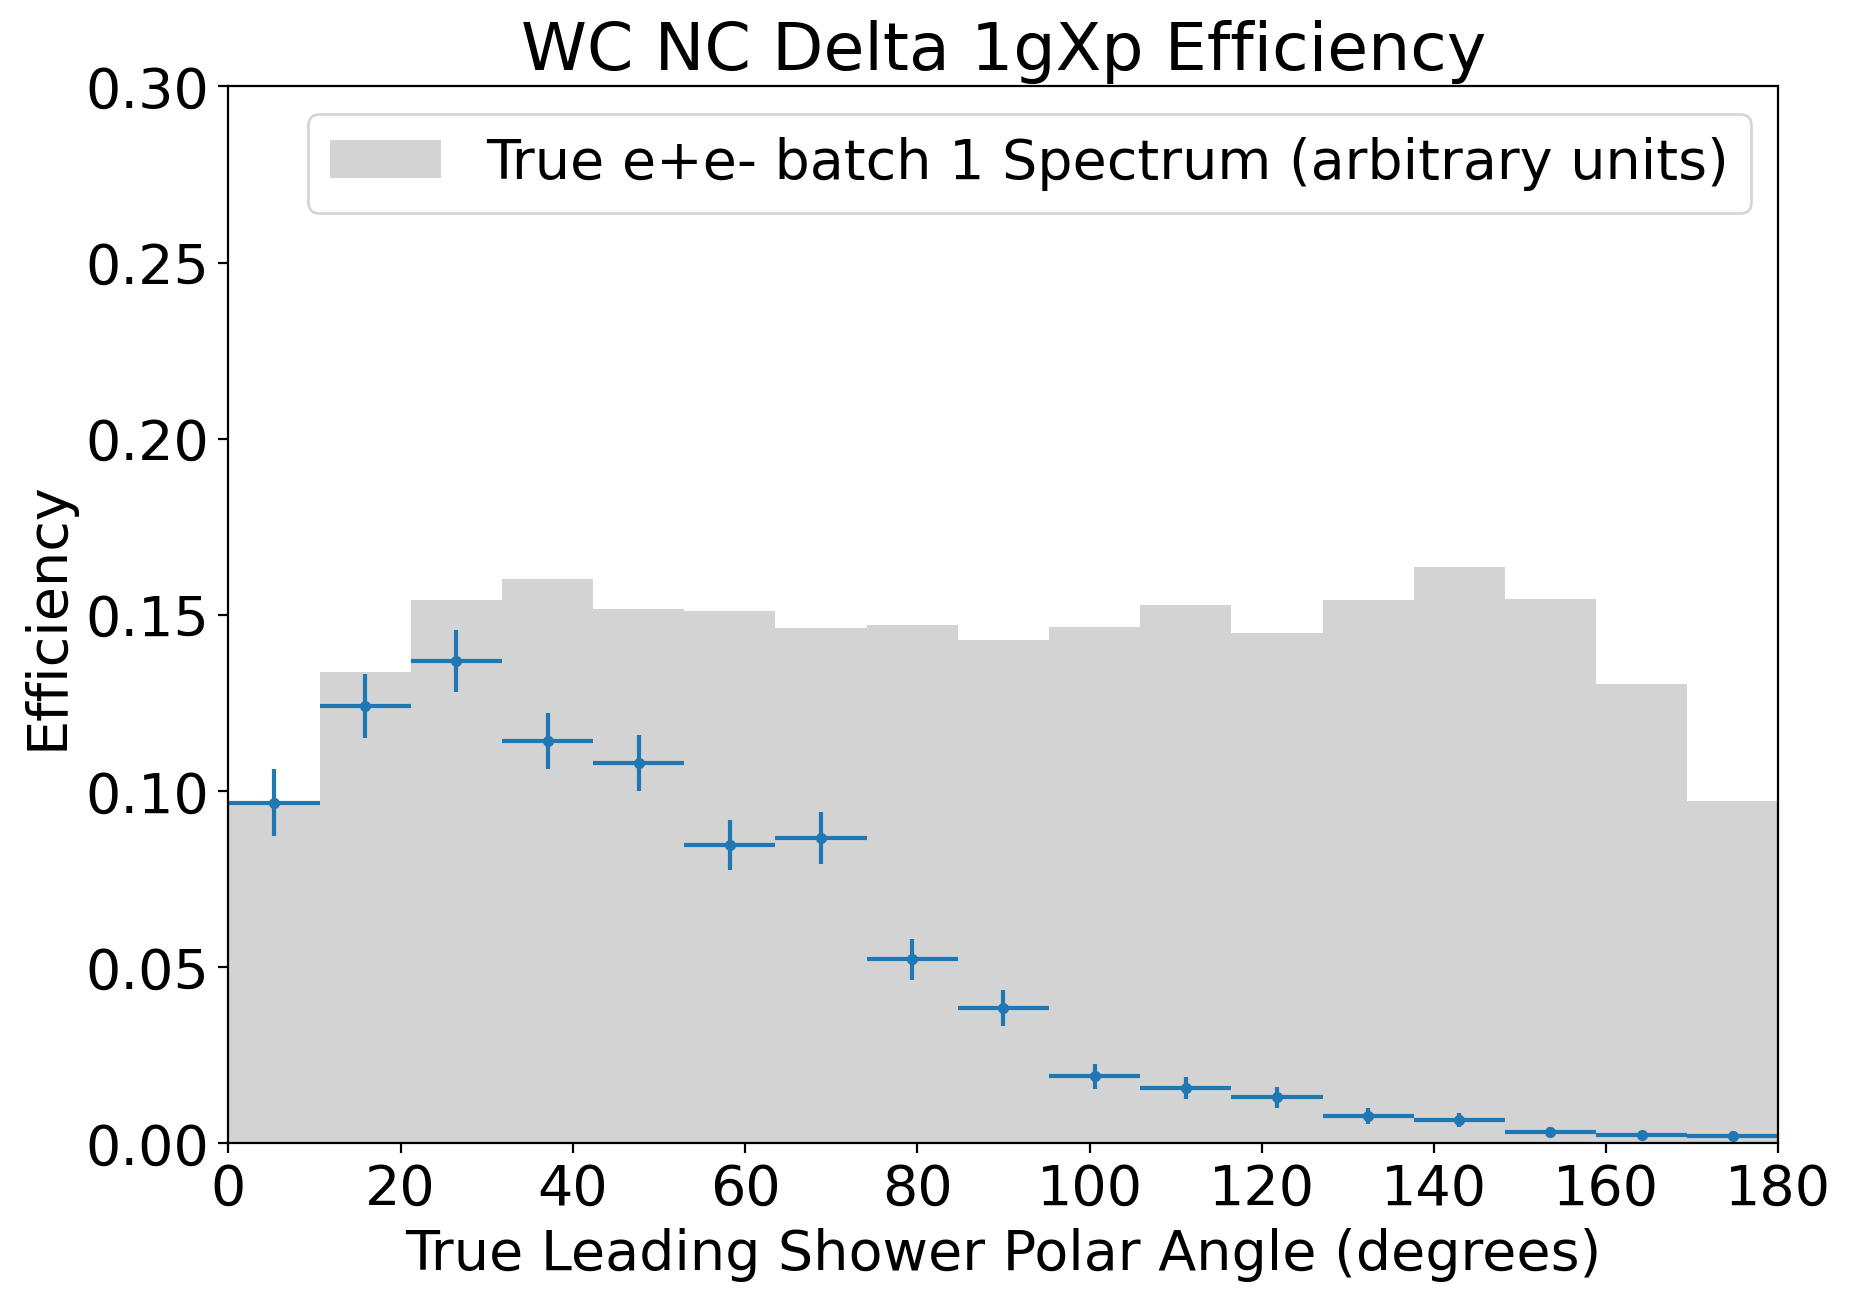

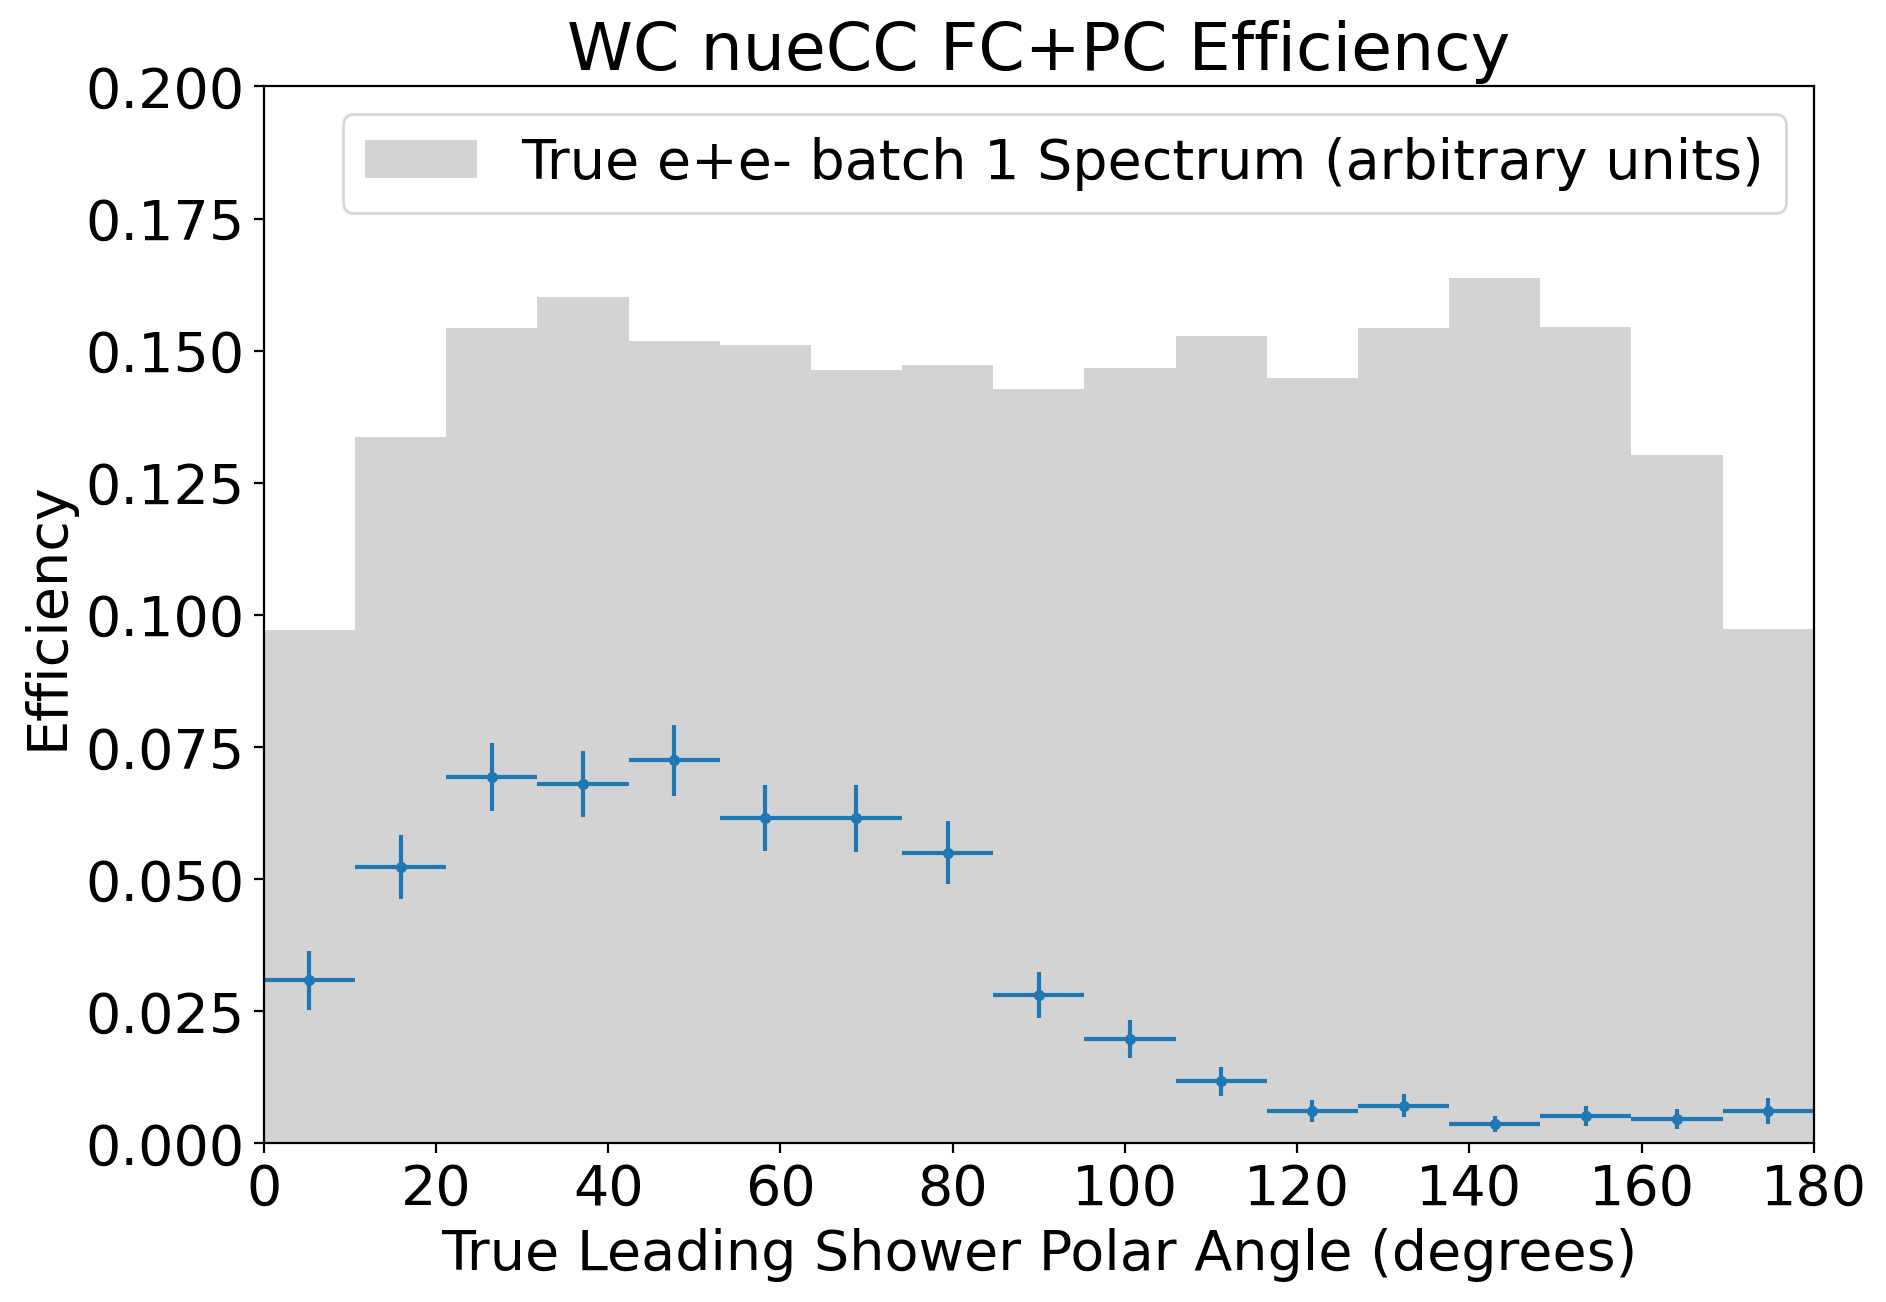

In [29]:
# 1D efficiencies by leading theta

sel_query = "kine_reco_Enu > 0"
title = "WC Generic Selection Efficiency"
filename = "eff_angle_generic"

bins = np.linspace(0., 180., 18)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_leading_shower_theta"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_leading_shower_theta"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_leading_shower_theta"].to_numpy(), bins=bins, weights=[0.0001 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Leading Shower Polar Angle (degrees)")
plt.ylabel("Efficiency")
plt.xlim(0., 180.)
plt.ylim(0., 1.)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")



sel_query = "match_isFC==1 and kine_reco_Enu > 0 and nc_delta_score > 2.61 and reco_showerKE > 0"
title = "WC NC Delta 1gXp Efficiency"
filename = "eff_angle_1gXp"

bins = np.linspace(0., 180., 18)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_leading_shower_theta"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_leading_shower_theta"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_leading_shower_theta"].to_numpy(), bins=bins, weights=[0.0001 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Leading Shower Polar Angle (degrees)")
plt.ylabel("Efficiency")
plt.xlim(0., 180.)
plt.ylim(0., 0.3)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")


sel_query = "kine_reco_Enu > 0 and nue_score > 7"
title = "WC nueCC FC+PC Efficiency"
filename = "eff_angle_nueCC"

bins = np.linspace(0., 180., 18)
bin_centers = [(bins[i + 1] + bins[i]) / 2. for i in range(len(bins) - 1)]
sel_df = all_df.query(sel_query)
counts_all, bin_edges_ = np.histogram(all_df["true_leading_shower_theta"].to_numpy(), bins=bins)
counts_sel, bin_edges_ = np.histogram(sel_df["true_leading_shower_theta"].to_numpy(), bins=bins)
eff_arr = []
eff_arr_sigma = []
for i in range(len(bins) - 1):
    # binomial error for k events chosen from n possibilities is sqrt(n * k/n * (1 - k/n))
    # total error on k is then sqrt(k * (1 - k/n))
    # error on k/n is sqrt(k * (1 - k/n)) / n
    eff_arr.append(counts_sel[i] / counts_all[i])
    eff_arr_sigma.append(np.sqrt(counts_sel[i] * (1. - counts_sel[i] / counts_all[i])) / counts_all[i])
plt.figure(dpi=200, figsize=(10,7))
plt.hist(all_df["true_leading_shower_theta"].to_numpy(), bins=bins, weights=[0.0001 for i in range(all_df.shape[0])], color="lightgrey", label="True e+e- batch 1 Spectrum (arbitrary units)")
plt.errorbar(bin_centers, eff_arr, xerr=0.5*(bins[1]-bins[0]), yerr=eff_arr_sigma, fmt='.')
plt.xlabel("True Leading Shower Polar Angle (degrees)")
plt.ylabel("Efficiency")
plt.xlim(0., 180.)
plt.ylim(0., 0.2)
plt.legend()
plt.title(title)
plt.savefig(f"plots/{filename}.png")



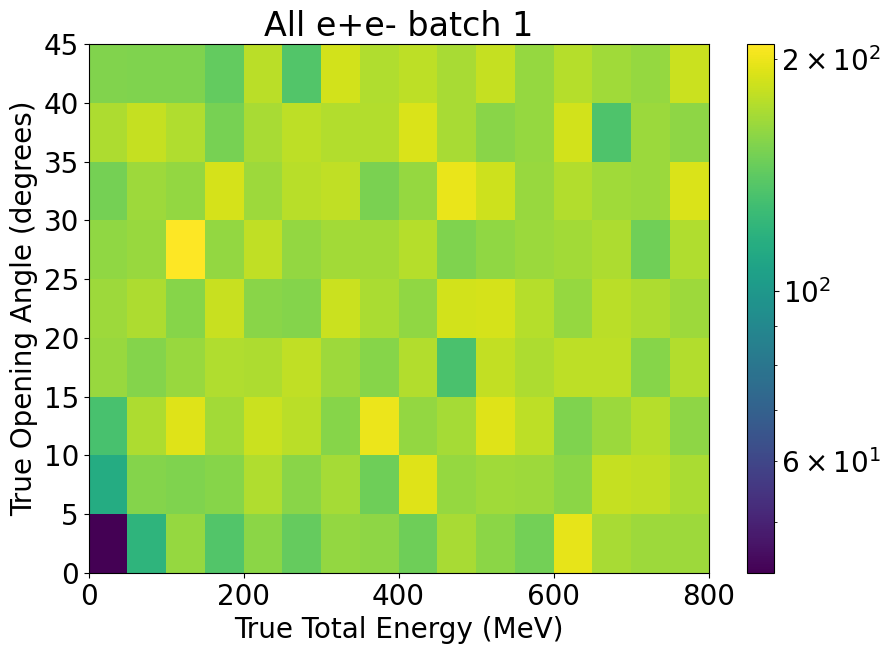

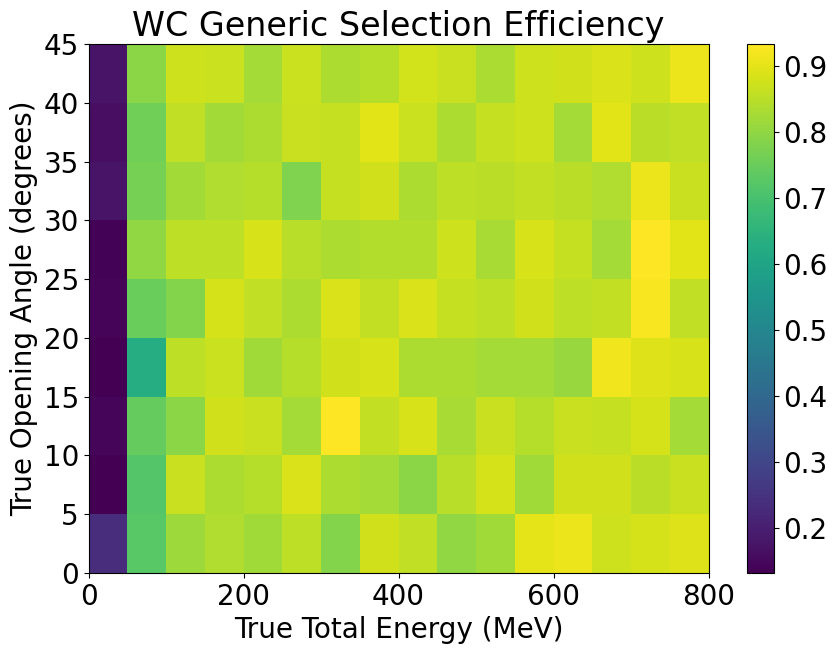

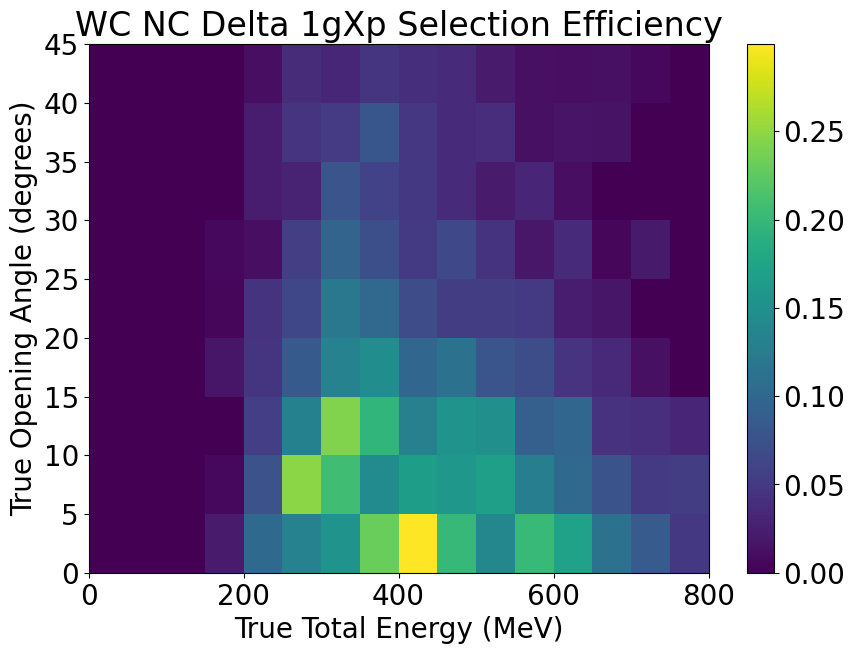

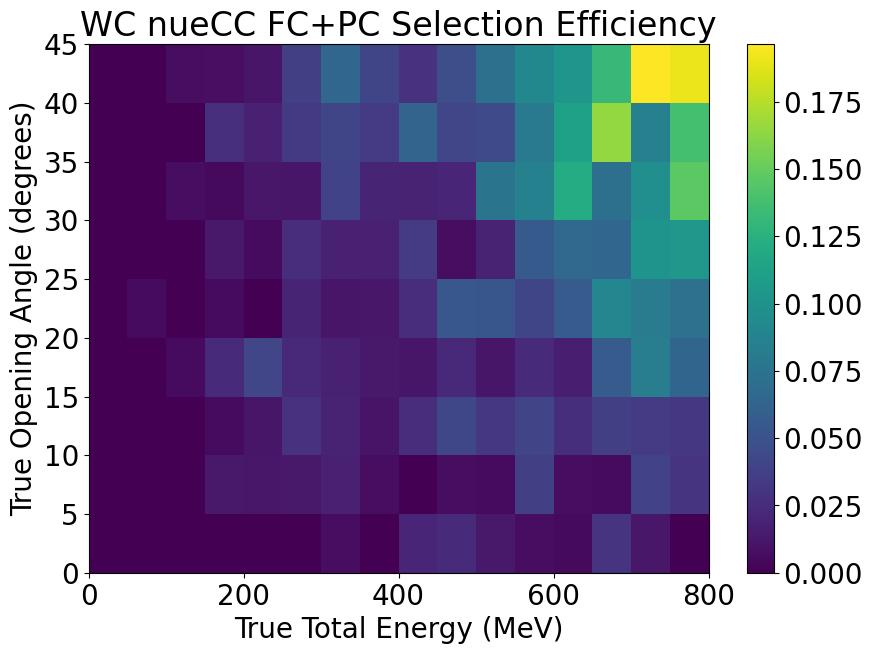

In [35]:
# 2D Efficiency by total energy and opening angle

xlabel = "True Total Energy (MeV)"
ylabel = "True Opening Angle (degrees)"
x_var = "true_total_energy"
y_var = "true_opening_angle"


sel_query = "kine_reco_Enu > 0"
title = "WC Generic Selection Efficiency"
filename = "total_energy_opening_generic"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
x_bin_edges = np.linspace(0., 800., 17)
y_bin_edges = np.linspace(0., 45., 10)
bins = (x_bin_edges, y_bin_edges)

plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(x, y, bins=bins, norm=mpl.colors.LogNorm())
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.title("All e+e- batch 1")
plt.savefig(f"plots/2d_dist_energy_opening.png")

selected_df = all_df.query(sel_query)
counts_all, x_edges_, y_edges_ = np.histogram2d(x, y, bins=bins)
x_sel = selected_df[x_var].to_numpy()
y_sel = selected_df[y_var].to_numpy()
counts_sel, x_edges_, y_edges_ = np.histogram2d(x_sel, y_sel, bins=bins)
eff_arr = []
bin_center_x_arr = []
bin_center_y_arr = []
for row in range(len(y_bin_edges) - 1):
    for col in range(len(x_bin_edges) - 1):
        bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
        bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
        numerator = counts_sel[col][row]
        denominator = counts_all[col][row]
        eff_arr.append(numerator / denominator)
plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=eff_arr, bins=bins)#, cmap="gist_rainbow")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
#plt.clim(0, 1)
plt.title(title)
plt.savefig(f"plots/2d_eff_{filename}.png")


sel_query = "match_isFC==1 and kine_reco_Enu > 0 and nc_delta_score > 2.61 and reco_showerKE > 0"
title = "WC NC Delta 1gXp Selection Efficiency"
filename = "total_energy_opening_1gXp"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
bins = (x_bin_edges, y_bin_edges)
selected_df = all_df.query(sel_query)
counts_all, x_edges_, y_edges_ = np.histogram2d(x, y, bins=bins)
x_sel = selected_df[x_var].to_numpy()
y_sel = selected_df[y_var].to_numpy()
counts_sel, x_edges_, y_edges_ = np.histogram2d(x_sel, y_sel, bins=bins)
eff_arr = []
bin_center_x_arr = []
bin_center_y_arr = []
for row in range(len(y_bin_edges) - 1):
    for col in range(len(x_bin_edges) - 1):
        bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
        bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
        numerator = counts_sel[col][row]
        denominator = counts_all[col][row]
        eff_arr.append(numerator / denominator)
plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=eff_arr, bins=bins)#, cmap="gist_rainbow")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
#plt.clim(0, 1)
plt.title(title)
plt.savefig(f"plots/2d_eff_{filename}.png")


sel_query = "kine_reco_Enu > 0 and nue_score > 7"
title = "WC nueCC FC+PC Selection Efficiency"
filename = "total_energy_opening_nueCC"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
bins = (x_bin_edges, y_bin_edges)
selected_df = all_df.query(sel_query)
counts_all, x_edges_, y_edges_ = np.histogram2d(x, y, bins=bins)
x_sel = selected_df[x_var].to_numpy()
y_sel = selected_df[y_var].to_numpy()
counts_sel, x_edges_, y_edges_ = np.histogram2d(x_sel, y_sel, bins=bins)
eff_arr = []
bin_center_x_arr = []
bin_center_y_arr = []
for row in range(len(y_bin_edges) - 1):
    for col in range(len(x_bin_edges) - 1):
        bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
        bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
        numerator = counts_sel[col][row]
        denominator = counts_all[col][row]
        eff_arr.append(numerator / denominator)
plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=eff_arr, bins=bins)#, cmap="gist_rainbow")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
#plt.clim(0, 1)
plt.title(title)
plt.savefig(f"plots/2d_eff_{filename}.png")


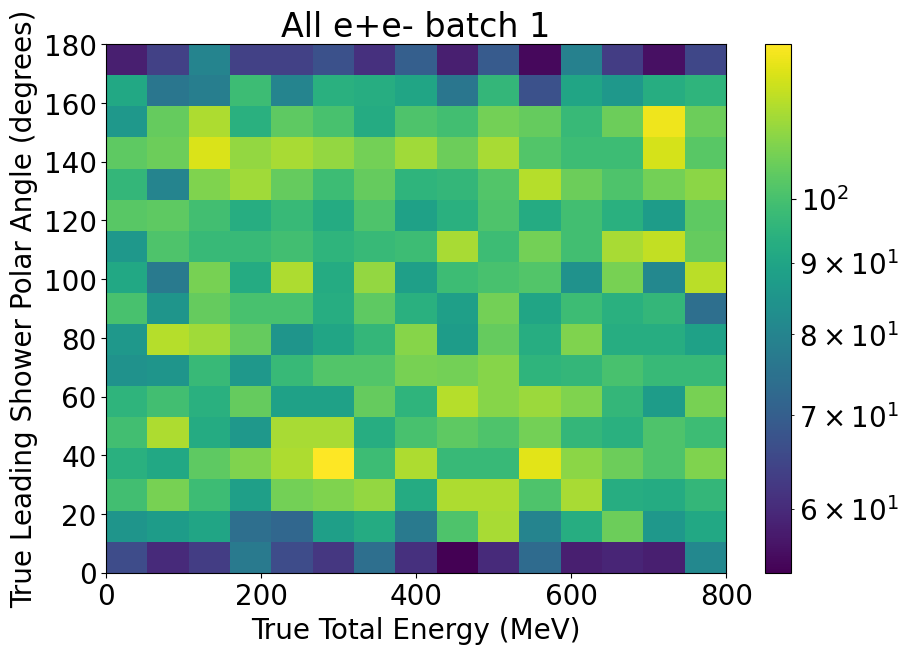

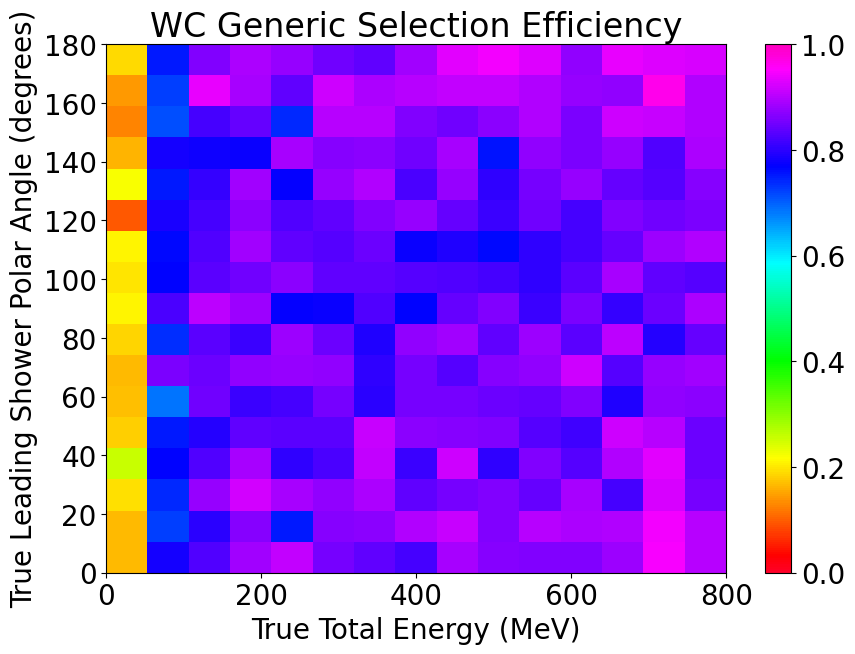

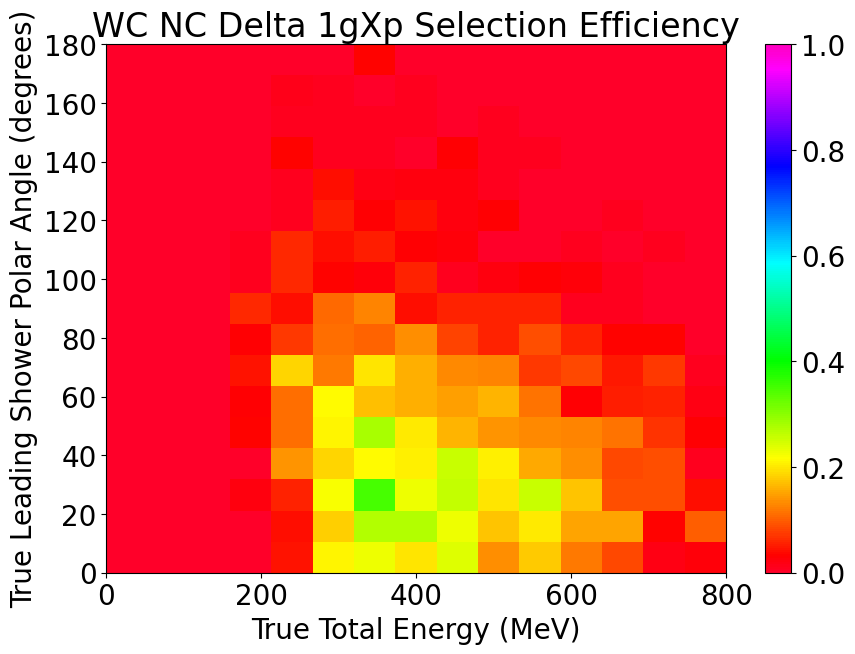

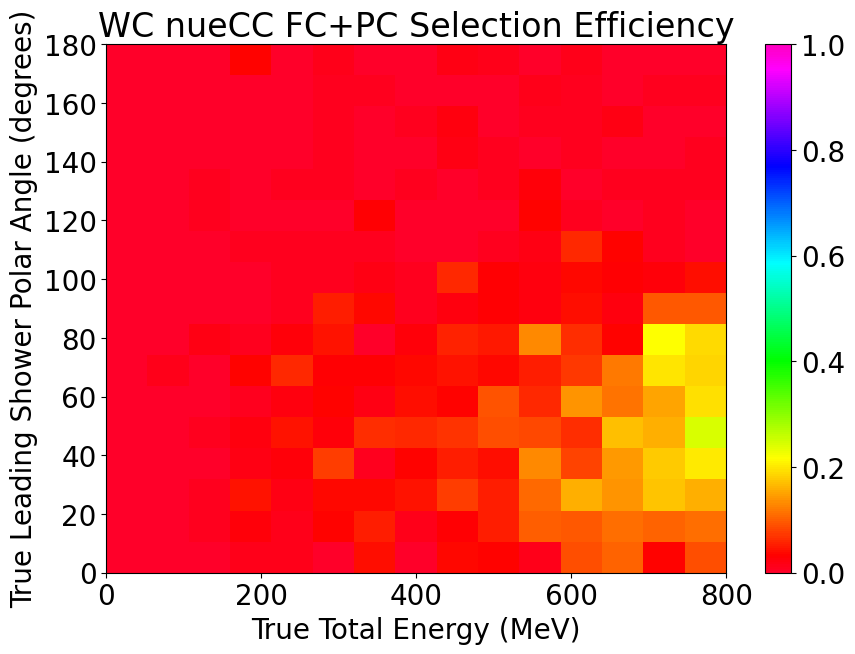

In [31]:
# 2D Efficiency by total energy and leading shower angle

xlabel = "True Total Energy (MeV)"
ylabel = "True Leading Shower Polar Angle (degrees)"
x_var = "true_total_energy"
y_var = "true_leading_shower_theta"


sel_query = "kine_reco_Enu > 0"
title = "WC Generic Selection Efficiency"
filename = "total_energy_angle_generic"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
x_bin_edges = np.linspace(0., 800., 16)
y_bin_edges = np.linspace(0., 180., 18)
bins = (x_bin_edges, y_bin_edges)

plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(x, y, bins=bins, norm=mpl.colors.LogNorm())
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.title("All e+e- batch 1")
plt.savefig(f"plots/2d_dist_energy_angle.png")

selected_df = all_df.query(sel_query)
counts_all, x_edges_, y_edges_ = np.histogram2d(x, y, bins=bins)
x_sel = selected_df[x_var].to_numpy()
y_sel = selected_df[y_var].to_numpy()
counts_sel, x_edges_, y_edges_ = np.histogram2d(x_sel, y_sel, bins=bins)
eff_arr = []
bin_center_x_arr = []
bin_center_y_arr = []
for row in range(len(y_bin_edges) - 1):
    for col in range(len(x_bin_edges) - 1):
        bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
        bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
        numerator = counts_sel[col][row]
        denominator = counts_all[col][row]
        eff_arr.append(numerator / denominator)
plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=eff_arr, bins=bins, cmap="gist_rainbow")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.clim(0, 1)
plt.title(title)
plt.savefig(f"plots/2d_eff_{filename}.png")


sel_query = "match_isFC==1 and kine_reco_Enu > 0 and nc_delta_score > 2.61 and reco_showerKE > 0"
title = "WC NC Delta 1gXp Selection Efficiency"
filename = "total_energy_angle_1gXp"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
bins = (x_bin_edges, y_bin_edges)
selected_df = all_df.query(sel_query)
counts_all, x_edges_, y_edges_ = np.histogram2d(x, y, bins=bins)
x_sel = selected_df[x_var].to_numpy()
y_sel = selected_df[y_var].to_numpy()
counts_sel, x_edges_, y_edges_ = np.histogram2d(x_sel, y_sel, bins=bins)
eff_arr = []
bin_center_x_arr = []
bin_center_y_arr = []
for row in range(len(y_bin_edges) - 1):
    for col in range(len(x_bin_edges) - 1):
        bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
        bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
        numerator = counts_sel[col][row]
        denominator = counts_all[col][row]
        eff_arr.append(numerator / denominator)
plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=eff_arr, bins=bins, cmap="gist_rainbow")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.clim(0, 1)
plt.title(title)
plt.savefig(f"plots/2d_eff_{filename}.png")


sel_query = "kine_reco_Enu > 0 and nue_score > 7"
title = "WC nueCC FC+PC Selection Efficiency"
filename = "total_energy_angle_nueCC"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
bins = (x_bin_edges, y_bin_edges)
selected_df = all_df.query(sel_query)
counts_all, x_edges_, y_edges_ = np.histogram2d(x, y, bins=bins)
x_sel = selected_df[x_var].to_numpy()
y_sel = selected_df[y_var].to_numpy()
counts_sel, x_edges_, y_edges_ = np.histogram2d(x_sel, y_sel, bins=bins)
eff_arr = []
bin_center_x_arr = []
bin_center_y_arr = []
for row in range(len(y_bin_edges) - 1):
    for col in range(len(x_bin_edges) - 1):
        bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
        bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
        numerator = counts_sel[col][row]
        denominator = counts_all[col][row]
        eff_arr.append(numerator / denominator)
plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=eff_arr, bins=bins, cmap="gist_rainbow")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.clim(0, 1)
plt.title(title)
plt.savefig(f"plots/2d_eff_{filename}.png")

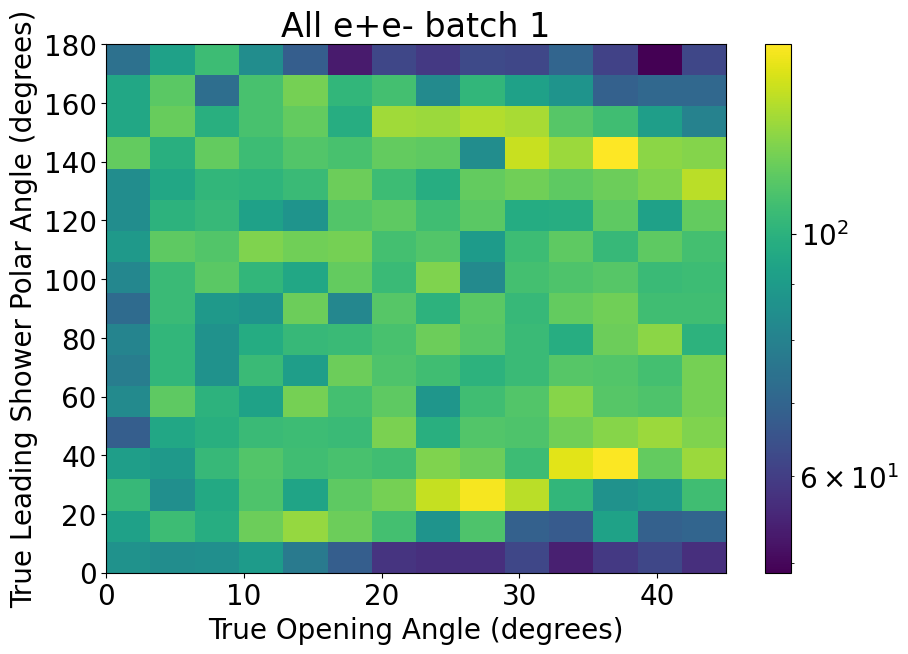

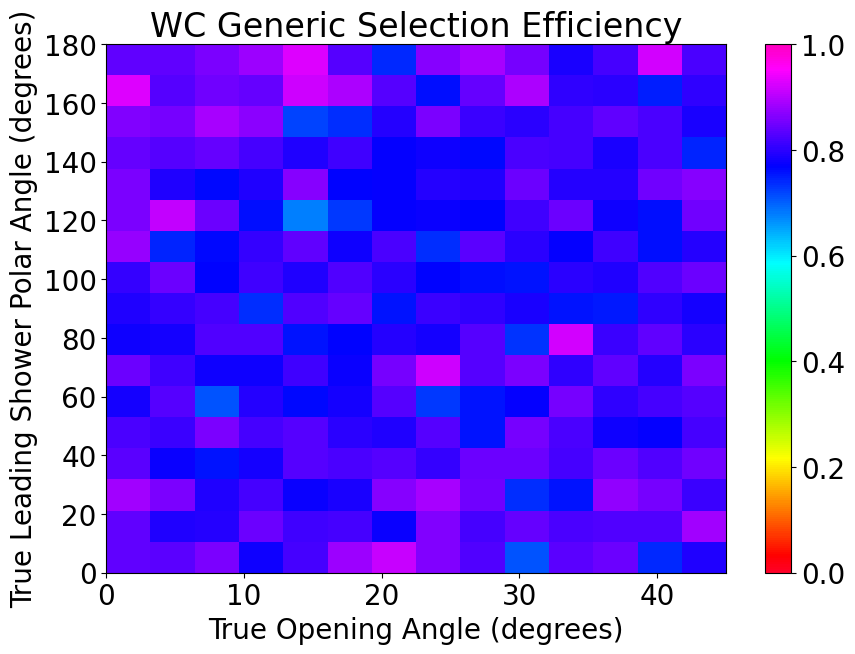

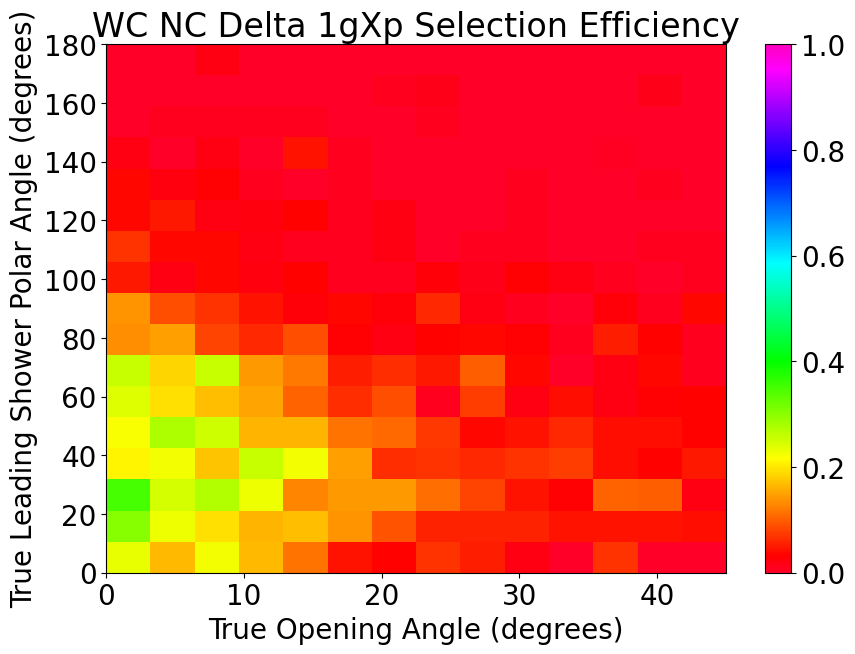

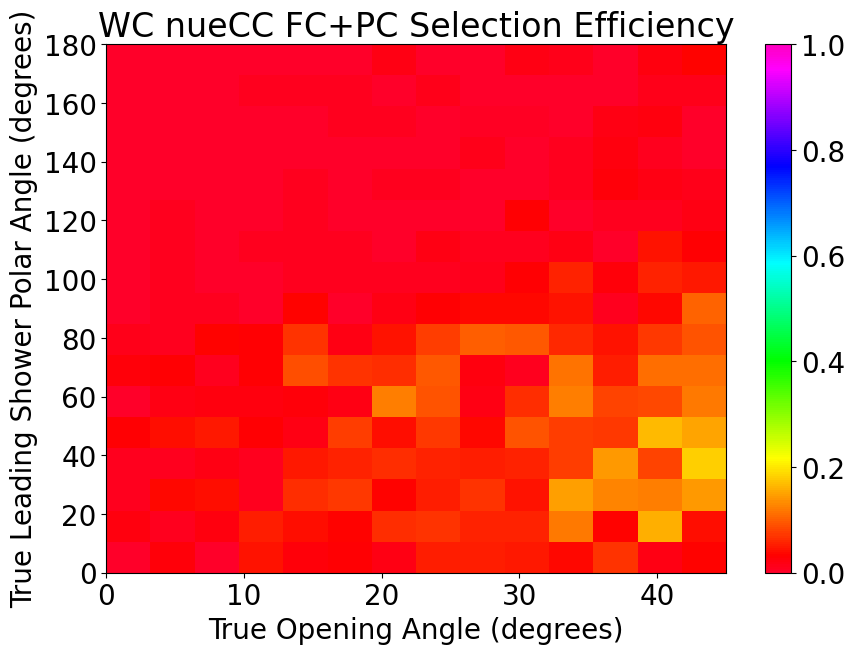

In [32]:
# 2D Efficiency by opening angle and leading shower angle

sel_query = "kine_reco_Enu > 0"
title = "WC Generic Selection Efficiency"
filename = "angle_opening_generic"

xlabel = "True Opening Angle (degrees)"
ylabel = "True Leading Shower Polar Angle (degrees)"
x_var = "true_opening_angle"
y_var = "true_leading_shower_theta"


sel_query = "kine_reco_Enu > 0"
title = "WC Generic Selection Efficiency"
filename = "angle_opening_generic"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
x_bin_edges = np.linspace(0., 45., 15)
y_bin_edges = np.linspace(0., 180., 18)
bins = (x_bin_edges, y_bin_edges)

plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(x, y, bins=bins, norm=mpl.colors.LogNorm())
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.title("All e+e- batch 1")
plt.savefig(f"plots/2d_dist_angle_opening.png")

selected_df = all_df.query(sel_query)
counts_all, x_edges_, y_edges_ = np.histogram2d(x, y, bins=bins)
x_sel = selected_df[x_var].to_numpy()
y_sel = selected_df[y_var].to_numpy()
counts_sel, x_edges_, y_edges_ = np.histogram2d(x_sel, y_sel, bins=bins)
eff_arr = []
bin_center_x_arr = []
bin_center_y_arr = []
for row in range(len(y_bin_edges) - 1):
    for col in range(len(x_bin_edges) - 1):
        bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
        bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
        numerator = counts_sel[col][row]
        denominator = counts_all[col][row]
        eff_arr.append(numerator / denominator)
plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=eff_arr, bins=bins, cmap="gist_rainbow")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.clim(0, 1)
plt.title(title)
plt.savefig(f"plots/2d_eff_{filename}.png")


sel_query = "match_isFC==1 and kine_reco_Enu > 0 and nc_delta_score > 2.61 and reco_showerKE > 0"
title = "WC NC Delta 1gXp Selection Efficiency"
filename = "angle_opening_1gXp"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
bins = (x_bin_edges, y_bin_edges)
selected_df = all_df.query(sel_query)
counts_all, x_edges_, y_edges_ = np.histogram2d(x, y, bins=bins)
x_sel = selected_df[x_var].to_numpy()
y_sel = selected_df[y_var].to_numpy()
counts_sel, x_edges_, y_edges_ = np.histogram2d(x_sel, y_sel, bins=bins)
eff_arr = []
bin_center_x_arr = []
bin_center_y_arr = []
for row in range(len(y_bin_edges) - 1):
    for col in range(len(x_bin_edges) - 1):
        bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
        bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
        numerator = counts_sel[col][row]
        denominator = counts_all[col][row]
        eff_arr.append(numerator / denominator)
plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=eff_arr, bins=bins, cmap="gist_rainbow")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.clim(0, 1)
plt.title(title)
plt.savefig(f"plots/2d_eff_{filename}.png")


sel_query = "kine_reco_Enu > 0 and nue_score > 7"
title = "WC nueCC FC+PC Selection Efficiency"
filename = "angle_opening_nueCC"

x = all_df[x_var].to_numpy()
y = all_df[y_var].to_numpy()
bins = (x_bin_edges, y_bin_edges)
selected_df = all_df.query(sel_query)
counts_all, x_edges_, y_edges_ = np.histogram2d(x, y, bins=bins)
x_sel = selected_df[x_var].to_numpy()
y_sel = selected_df[y_var].to_numpy()
counts_sel, x_edges_, y_edges_ = np.histogram2d(x_sel, y_sel, bins=bins)
eff_arr = []
bin_center_x_arr = []
bin_center_y_arr = []
for row in range(len(y_bin_edges) - 1):
    for col in range(len(x_bin_edges) - 1):
        bin_center_x_arr.append(x_bin_edges[col] + (x_bin_edges[1] - x_bin_edges[0]) / 2.)
        bin_center_y_arr.append(y_bin_edges[row] + (y_bin_edges[1] - y_bin_edges[0]) / 2.)
        numerator = counts_sel[col][row]
        denominator = counts_all[col][row]
        eff_arr.append(numerator / denominator)
plt.figure(dpi=100, figsize=(10,7))
plt.hist2d(bin_center_x_arr, bin_center_y_arr, weights=eff_arr, bins=bins, cmap="gist_rainbow")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.colorbar()
plt.clim(0, 1)
plt.title(title)
plt.savefig(f"plots/2d_eff_{filename}.png")

In [33]:
# add nc pi0 selections (maybe would need to talk to Giacomo first, probably wouldn't be very good regardless)



# add true-reco vertex difference



# talk to pawel about nc delta score


# 